# Import required Modules
* install scikit-multiflow to import drift detection algorithm
* Mount on google drive to load datasets.

In [1]:
!pip install -q scikit-multiflow

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 450.6/450.6 kB 5.2 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done


In [2]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, classification_report
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from skmultiflow.drift_detection import ADWIN, DDM
from sklearn.neighbors import KNeighborsClassifier
from warnings import simplefilter,filterwarnings
from sklearn.preprocessing import StandardScaler
from sklearn.tree import DecisionTreeClassifier
from sklearn.preprocessing import OneHotEncoder
from matplotlib.colors import ListedColormap
from multiprocessing.pool import ThreadPool
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import roc_auc_score
from imblearn.over_sampling import SMOTE
from sklearn.utils import shuffle
from contextlib import suppress
from collections import Counter
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm
from random import shuffle
import seaborn as sns
from time import time
import pandas as pd
import numpy as np
import scipy.io
import pickle
import sys
import gc
import os
import re
filterwarnings('ignore')
filterwarnings(action='once')
# os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'
# # simplefilter('ignore', FutureWarning)
# with suppress(WARNING):

In [3]:
from google.colab import drive
drive.mount('/content/drive')

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)
/usr/local/lib/python3.10/dist-packages/pexpect/popen_spawn.py:60: DeprecationWarning: setDaemon() is deprecated, set the daemon attribute instead
  self._read_thread.setDaemon(True)


Mounted at /content/drive


In [4]:
data_path = '/content/drive/My Drive/Colab Notebooks/Muawiya/Genetic Programming Combiner with DFS/data'
code_path = '/content/drive/My Drive/Colab Notebooks/Muawiya/Genetic Programming Combiner with DFS/codes'
results_path = '/content/drive/My Drive/Colab Notebooks/Muawiya/Genetic Programming Combiner with DFS/results'

# Componentes

In [5]:
filenames = ['kddcup99_csv.csv','ISCX2012.csv','CSE-CIC2018.csv','CICIDS2017.csv','7recurrentDrift.csv', 'blip.csv', 'incrementalDrift.csv',
             '7gradualDrift.csv', '7suddenDrift.csv']
filenames = list(map(lambda x: os.path.join(data_path, x), filenames))
filenames

['/content/drive/My Drive/Colab Notebooks/Muawiya/Genetic Programming Combiner with DFS/data/kddcup99_csv.csv',
 '/content/drive/My Drive/Colab Notebooks/Muawiya/Genetic Programming Combiner with DFS/data/ISCX2012.csv',
 '/content/drive/My Drive/Colab Notebooks/Muawiya/Genetic Programming Combiner with DFS/data/CSE-CIC2018.csv',
 '/content/drive/My Drive/Colab Notebooks/Muawiya/Genetic Programming Combiner with DFS/data/CICIDS2017.csv',
 '/content/drive/My Drive/Colab Notebooks/Muawiya/Genetic Programming Combiner with DFS/data/7recurrentDrift.csv',
 '/content/drive/My Drive/Colab Notebooks/Muawiya/Genetic Programming Combiner with DFS/data/blip.csv',
 '/content/drive/My Drive/Colab Notebooks/Muawiya/Genetic Programming Combiner with DFS/data/incrementalDrift.csv',
 '/content/drive/My Drive/Colab Notebooks/Muawiya/Genetic Programming Combiner with DFS/data/7gradualDrift.csv',
 '/content/drive/My Drive/Colab Notebooks/Muawiya/Genetic Programming Combiner with DFS/data/7suddenDrift.csv']

In [6]:
def save_pickle(obj, file_name):
  with open(file_name, 'wb') as f:
    pickle.dump(obj, f)
def load_pickle(file_name):
  with open(file_name, 'rb') as f:
    d = pickle.load(f)
  return d

# Result Visulization Section


In [7]:
def load_pickle(file_name):
    with open(file_name, 'rb') as f:
      d = pickle.load(f)
      if len(d.keys()) > 1:
        dd = {}
        dd['dataset'] = d
        return dd
      return d

In [8]:
def load_time_serires_data(data_path):
    data = load_pickle("{}".format(data_path))
    y_true, y_pred = [], []
    for key in data.keys():
        for i in range(1, len(data[key])):
          f = data[key][i]
          try:
            y_true += f['y_true'].tolist()
            y_pred += f['y_pred'].tolist()
          except:
            y_true += f['y_true']
            y_pred += f['y_pred']
    return np.array(y_true).astype('int'), np.array(y_pred).astype('int')

In [9]:
def read_drift_location_data(data_path, step_size):
    data = load_pickle(data_path)
    for key in data:
        drift_locations = list(data[key].keys())
    drift_locations.sort()
    drift_locations__ = []
    for i in range(1, len(drift_locations)):
        if drift_locations[i] - drift_locations[i-1] > 5000 and drift_locations[i] < 80000:
          drift_locations__.append(drift_locations[i])
    return drift_locations__

In [10]:
metric_functions = {'accuracy': accuracy_score, 'precision': precision_score,
                        'recall': recall_score, 'f1_score': f1_score, 'auc': roc_auc_score}
def cummulative_metrics(y_true, y_pred, step_size, metric):

    metric_score = []
    for i in range(step_size, len(y_true) - step_size, step_size):
        try:
          metric_score.append(metric_functions[metric](y_true[:i], y_pred[:i]))
        except:
          metric_score.append(0.5)
    return metric_score


In [11]:
def time_series_plot(data_path, drift_data_path, step_size, title, metric, method_names):
    if type(data_path) is not list:
      method_names = [method_names]
      data_path = [data_path]
    fig = plt.figure(figsize=(12, 8))
    colors = ['red', 'green', 'blue', 'magenta', 'pink','saddlebrown','darkorange','indigo']
    j = 0
    for d_path, method_name, path in zip(data_path, method_names, drift_data_path):
        y_true, y_pred = load_time_serires_data(d_path)
        metric_score = cummulative_metrics(y_true, y_pred, step_size, metric)
        X = np.linspace(0, 80000, len(metric_score))
        plt.plot(X, metric_score, label='{}'.format(method_name), color=colors[j])
        drift_locations  = read_drift_location_data(path, step_size)
        for loc in drift_locations:

          X_diff = np.abs(X - loc)
          closest_point = X_diff.argmin()
          y_value = metric_score[closest_point]
          plt.plot(loc, y_value, marker="o", markersize=9, markerfacecolor=colors[j])
        j += 1
    plt.xlabel("Time Series")
    plt.ylabel("{}".format(metric))
    plt.title(title[0])
    plt.legend(loc='best')
    plt.savefig("/content/drive/My Drive/Colab Notebooks/Muawiya/Genetic Programming Combiner with DFS/Images/{}/{}_{}.png".format(title[1],title[0], metric))
    plt.savefig("/content/drive/My Drive/Colab Notebooks/Muawiya/Genetic Programming Combiner with DFS/Images/{}/{}_{}.svg".format(title[1],title[0], metric))
    plt.show()

In [12]:
plt.style.use('ggplot')
def bar_chart_plot(data_path, title, metric, method_names, xticks):
    if type(data_path) is not list:
      method_names = [method_names]
      data_path = [data_path]
    heights = []
    fig = plt.figure(figsize=(12, 8))
    data_path = np.split(np.array(data_path), len(xticks))

    for d_path in data_path:
        h = []
        for path in d_path:
          y_true, y_pred = load_time_serires_data(path)
          h.append(metric_functions[metric](y_true, y_pred))
        heights.append(h)
    width = 0.7
    print(len(heights))
    X = np.array([0.1, 0.2, 0.3, 0.4, 0.5,0.6,0.7,0.8,0.9])
    colors = ['g', 'r', 'cyan', 'gray', 'y','blue','black','orange','magenta']
    for i in range(len(heights)):
        for j in range(len(method_names)):
          plt.bar(X[j], heights[i][j], width=0.1, color=colors[j])
        X += width
    plt.xlabel("Dataset Names")
    plt.xticks([0.25, 0.95, 1.65, 2.35, 3.05,3.75,4.45,5.85,6.55], xticks)
    plt.ylabel("{}".format(metric))
    plt.title(title)
    plt.legend(method_names, bbox_to_anchor=(1.1, 1.05),loc='best')
    plt.savefig("{}.png".format(title))
    plt.savefig("{}.svg".format(title))
    plt.show()

In [13]:
!pip install -q dataframe_image

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.6/6.6 MB 61.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 399.7/399.7 kB 39.5 MB/s eta 0:00:00


In [14]:
from collections import defaultdict
from pandas.plotting import table
import dataframe_image as dfi

def result_as_df(data_path, metrics, method_names,title):

    result = defaultdict(lambda: [])
    for d_path, method_name in zip(data_path, method_names):
        ############
        for metric in metrics:
          y_true, y_pred = load_time_serires_data(d_path)
          metric_score = metric_functions[metric](y_true, y_pred)
          result[metric].append(metric_score)
    df = pd.DataFrame(result)
    df.index = method_names
    df = df.sort_values(by='f1_score', ascending=False).T
    df.to_csv('/content/drive/My Drive/Colab Notebooks/Muawiya/Genetic Programming Combiner with DFS/CSV/'+title+'.csv')
    return df

<frozen importlib._bootstrap>:914: ImportWarning: APICoreClientInfoImportHook.find_spec() not found; falling back to find_module()
<frozen importlib._bootstrap>:914: ImportWarning: _PyDriveImportHook.find_spec() not found; falling back to find_module()
<frozen importlib._bootstrap>:914: ImportWarning: _OpenCVImportHook.find_spec() not found; falling back to find_module()
<frozen importlib._bootstrap>:914: ImportWarning: _BokehImportHook.find_spec() not found; falling back to find_module()
<frozen importlib._bootstrap>:914: ImportWarning: _AltairImportHook.find_spec() not found; falling back to find_module()
<frozen importlib._bootstrap>:914: ImportWarning: APICoreClientInfoImportHook.find_spec() not found; falling back to find_module()
<frozen importlib._bootstrap>:914: ImportWarning: _PyDriveImportHook.find_spec() not found; falling back to find_module()
<frozen importlib._bootstrap>:914: ImportWarning: _OpenCVImportHook.find_spec() not found; falling back to find_module()
<frozen imp

In [15]:
method_names = ["GPC-OS RandomForest","GPC-OS DFS", "GPC-FOS RandomForest","GPC-FOS DFS ",  "GPC-KOS RandomForest","GPC-KOS DFS","GPC RandomForest", "GPC DFS"]
metrices = ['accuracy', 'precision', 'recall', 'f1_score', 'auc']

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


# Gradual Result Visualization




In [ ]:
gradual_results_1 = [
                   "/content/drive/My Drive/Colab Notebooks/Muawiya/Genetic Programming Combiner with DFS/results/gp_combiner_with_model_replacement_evolving_random_forest/7gradualDrift.csv/7gradualDrift.csv_results.pkl",
                   "/content/drive/My Drive/Colab Notebooks/Muawiya/Genetic Programming Combiner with DFS/results/gp_combiner_with_model_replacement_evolving_DFS/7gradualDrift.csv/7gradualDrift.csv_results.pkl",
                   "/content/drive/My Drive/Colab Notebooks/Muawiya/Genetic Programming Combiner with DFS/results/faoselm_gp_combiner_with_model_replacement_evolving_random_forest/7gradualDrift.csv/7gradualDrift.csv_results.pkl",
                  #  "/content/drive/My Drive/Colab Notebooks/Muawiya/Genetic Programming Combiner with DFS/results/faoselm_gp_combiner_with_model_replacement_evolving_DFS/7gradualDrift.csv/7gradualDrift.csv_results.pkl",
                  #  "/content/drive/My Drive/Colab Notebooks/Muawiya/Genetic Programming Combiner with DFS/results/kpfaoselm_gp_combiner_with_model_replacement_evolving_random_forest/7gradualDrift.csv/7gradualDrift.csv_results.pkl",
                  #  "/content/drive/My Drive/Colab Notebooks/Muawiya/Genetic Programming Combiner with DFS/results/kpfaoselm_gp_combiner_with_model_replacement_evolving_DFS/7gradualDrift.csv/7gradualDrift.csv_results.pkl",
                  #  "/content/drive/My Drive/Colab Notebooks/Muawiya/Genetic Programming Combiner with DFS/results/ml_gp_combiner_with_model_replacement_evolving_random_forest/7gradualDrift.csv/7gradualDrift.csv_results.pkl",
                  #  "/content/drive/My Drive/Colab Notebooks/Muawiya/Genetic Programming Combiner with DFS/results/ml_gp_combiner_with_model_replacement_evolving_DFS/7gradualDrift.csv/7gradualDrift.csv_results.pkl",
                    ]
drift_location_path = [
                       "/content/drive/My Drive/Colab Notebooks/Muawiya/Genetic Programming Combiner with DFS/results/gp_combiner_with_model_replacement_evolving_random_forest/7gradualDrift.csv/7gradualDrift.csv_drift_locations_in_all_dataset.pkl",
                       "/content/drive/My Drive/Colab Notebooks/Muawiya/Genetic Programming Combiner with DFS/results/gp_combiner_with_model_replacement_evolving_DFS/7gradualDrift.csv/7gradualDrift.csv_drift_locations_in_all_dataset.pkl",
                       "/content/drive/My Drive/Colab Notebooks/Muawiya/Genetic Programming Combiner with DFS/results/faoselm_gp_combiner_with_model_replacement_evolving_random_forest/7gradualDrift.csv/7gradualDrift.csv_drift_locations_in_all_dataset.pkl",
                      #  "/content/drive/My Drive/Colab Notebooks/Muawiya/Genetic Programming Combiner with DFS/results/faoselm_gp_combiner_with_model_replacement_evolving_DFS/7gradualDrift.csv/7gradualDrift.csv_drift_locations_in_all_dataset.pkl",
                      #  "/content/drive/My Drive/Colab Notebooks/Muawiya/Genetic Programming Combiner with DFS/results/kpfaoselm_gp_combiner_with_model_replacement_evolving_random_forest/7gradualDrift.csv/7gradualDrift.csv_drift_locations_in_all_dataset.pkl",
                      #  "/content/drive/My Drive/Colab Notebooks/Muawiya/Genetic Programming Combiner with DFS/results/kpfaoselm_gp_combiner_with_model_replacement_evolving_DFS/7gradualDrift.csv/7gradualDrift.csv_drift_locations_in_all_dataset.pkl",
                      #  "/content/drive/My Drive/Colab Notebooks/Muawiya/Genetic Programming Combiner with DFS/results/ml_gp_combiner_with_model_replacement_evolving_random_forest/7gradualDrift.csv/7gradualDrift.csv_drift_locations_in_all_dataset.pkl",
                      #  "/content/drive/My Drive/Colab Notebooks/Muawiya/Genetic Programming Combiner with DFS/results/ml_gp_combiner_with_model_replacement_evolving_DFS/7gradualDrift.csv/7gradualDrift.csv_drift_locations_in_all_dataset.pkl",
                       ]
# try:
time_series_plot(data_path=gradual_results_1, drift_data_path=drift_location_path, step_size=100,
                title=["Gradual Drift With Evolving","Gradual Drift"], metric="precision", method_names=method_names)
time_series_plot(data_path=gradual_results_1, drift_data_path=drift_location_path, step_size=100,
                title=["Gradual Drift With Evolving","Gradual Drift"], metric="accuracy", method_names=method_names)
time_series_plot(data_path=gradual_results_1, drift_data_path=drift_location_path, step_size=100,
                title=["Gradual Drift With Evolving","Gradual Drift"], metric="recall", method_names=method_names)
time_series_plot(data_path=gradual_results_1, drift_data_path=drift_location_path, step_size=100,
                title=["Gradual Drift With Evolving","Gradual Drift"], metric="f1_score", method_names=method_names)
time_series_plot(data_path=gradual_results_1, drift_data_path=drift_location_path, step_size=100,
                title=["Gradual Drift With Evolving","Gradual Drift"], metric="auc", method_names=method_names)
  # result_as_df(gradual_results_1, metrices, method_names,title="Gradual Drift With Evolving")
# except:
#   print("error in path")

In [ ]:
gradual_results_2 = [
                   "/content/drive/My Drive/Colab Notebooks/Muawiya/Genetic Programming Combiner with DFS/results/gp_combiner_with_model_replacement_evolving_random_forest/7gradualDrift.csv/7gradualDrift.csv_results.pkl",
                   "/content/drive/My Drive/Colab Notebooks/Muawiya/Genetic Programming Combiner with DFS/results/gp_combiner_with_model_replacement_dynamic_feature_selection/7gradualDrift.csv/7gradualDrift.csv_results.pkl",
                  #  "/content/drive/My Drive/Colab Notebooks/Muawiya/Genetic Programming Combiner with DFS/results/faoselm_gp_combiner_with_model_replacement_random_forest/7gradualDrift.csv/7gradualDrift.csv_results.pkl",
                  #  "/content/drive/My Drive/Colab Notebooks/Muawiya/Genetic Programming Combiner with DFS/results/faoselm_gp_combiner_with_model_replacement_dynamic_feature_selection/7gradualDrift.csv/7gradualDrift.csv_results.pkl",
                  #  "/content/drive/My Drive/Colab Notebooks/Muawiya/Genetic Programming Combiner with DFS/results/kpfaoselm_gp_combiner_with_model_replacement_random_forest/7gradualDrift.csv/7gradualDrift.csv_results.pkl",
                  #  "/content/drive/My Drive/Colab Notebooks/Muawiya/Genetic Programming Combiner with DFS/results/kpfaoselm_gp_combiner_with_model_replacement_dynamic_feature_selection/7gradualDrift.csv/7gradualDrift.csv_results.pkl",
                  #  "/content/drive/My Drive/Colab Notebooks/Muawiya/Genetic Programming Combiner with DFS/results/ml_gp_combiner_with_model_replacement_random_forest/7gradualDrift.csv/7gradualDrift.csv_results.pkl",
                  #  "/content/drive/My Drive/Colab Notebooks/Muawiya/Genetic Programming Combiner with DFS/results/ml_gp_combiner_with_model_replacement_dynamic_feature_selection/7gradualDrift.csv/7gradualDrift.csv_results.pkl",
                   ]
drift_location_path = [
                       "/content/drive/My Drive/Colab Notebooks/Muawiya/Genetic Programming Combiner with DFS/results/gp_combiner_with_model_replacement_random_forest/7gradualDrift.csv/7gradualDrift.csv_drift_locations_in_all_dataset.pkl",
                       "/content/drive/My Drive/Colab Notebooks/Muawiya/Genetic Programming Combiner with DFS/results/gp_combiner_with_model_replacement_dynamic_feature_selection/7gradualDrift.csv/7gradualDrift.csv_drift_locations_in_all_dataset.pkl",
                      #  "/content/drive/My Drive/Colab Notebooks/Muawiya/Genetic Programming Combiner with DFS/results/faoselm_gp_combiner_with_model_replacement_random_forest/7gradualDrift.csv/7gradualDrift.csv_drift_locations_in_all_dataset.pkl",
                      #  "/content/drive/My Drive/Colab Notebooks/Muawiya/Genetic Programming Combiner with DFS/results/faoselm_gp_combiner_with_model_replacement_dynamic_feature_selection/7gradualDrift.csv/7gradualDrift.csv_drift_locations_in_all_dataset.pkl",
                      #  "/content/drive/My Drive/Colab Notebooks/Muawiya/Genetic Programming Combiner with DFS/results/kpfaoselm_gp_combiner_with_model_replacement_random_forest/7gradualDrift.csv/7gradualDrift.csv_drift_locations_in_all_dataset.pkl",
                      #  "/content/drive/My Drive/Colab Notebooks/Muawiya/Genetic Programming Combiner with DFS/results/kpfaoselm_gp_combiner_with_model_replacement_dynamic_feature_selection/7gradualDrift.csv/7gradualDrift.csv_drift_locations_in_all_dataset.pkl",
                      #  "/content/drive/My Drive/Colab Notebooks/Muawiya/Genetic Programming Combiner with DFS/results/ml_gp_combiner_with_model_replacement_random_forest/7gradualDrift.csv/7gradualDrift.csv_drift_locations_in_all_dataset.pkl",
                      #  "/content/drive/My Drive/Colab Notebooks/Muawiya/Genetic Programming Combiner with DFS/results/ml_gp_combiner_with_model_replacement_dynamic_feature_selection/7gradualDrift.csv/7gradualDrift.csv_drift_locations_in_all_dataset.pkl",
                       ]
# try:
time_series_plot(data_path=gradual_results_2, drift_data_path=drift_location_path, step_size=100,
                title=["Gradual Drift Without Evolving","Gradual Drift"], metric="precision", method_names=method_names)
time_series_plot(data_path=gradual_results_2, drift_data_path=drift_location_path, step_size=100,
                title=["Gradual Drift Without Evolving","Gradual Drift"], metric="accuracy", method_names=method_names)
time_series_plot(data_path=gradual_results_2, drift_data_path=drift_location_path, step_size=100,
                title=["Gradual Drift Without Evolving","Gradual Drift"], metric="recall", method_names=method_names)
time_series_plot(data_path=gradual_results_2, drift_data_path=drift_location_path, step_size=100,
                title=["Gradual Drift Without Evolving","Gradual Drift"], metric="f1_score", method_names=method_names)
time_series_plot(data_path=gradual_results_2, drift_data_path=drift_location_path, step_size=100,
                title=["Gradual Drift Without Evolving","Gradual Drift"], metric="auc", method_names=method_names)
  # result_as_df(gradual_results_2, metrices, method_names,title="Gradual Drift Without Evolving")
# except:
#   print("error in path")

# Blip Drift Visulization

In [ ]:
blip_results_1 = [
                   "/content/drive/My Drive/Colab Notebooks/Muawiya/Genetic Programming Combiner with DFS/results/gp_combiner_with_model_replacement_evolving_random_forest/blip.csv/blip.csv_results.pkl",
                   "/content/drive/My Drive/Colab Notebooks/Muawiya/Genetic Programming Combiner with DFS/results/gp_combiner_with_model_replacement_evolving_DFS/blip.csv/blip.csv_results.pkl",
                   "/content/drive/My Drive/Colab Notebooks/Muawiya/Genetic Programming Combiner with DFS/results/faoselm_gp_combiner_with_model_replacement_evolving_random_forest/blip.csv/blip.csv_results.pkl",
                  #  "/content/drive/My Drive/Colab Notebooks/Muawiya/Genetic Programming Combiner with DFS/results/faoselm_gp_combiner_with_model_replacement_evolving_DFS/blip.csv/blip.csv_results.pkl",
                  #  "/content/drive/My Drive/Colab Notebooks/Muawiya/Genetic Programming Combiner with DFS/results/kpfaoselm_gp_combiner_with_model_replacement_evolving_random_forest/blip.csv/blip.csv_results.pkl",
                  #  "/content/drive/My Drive/Colab Notebooks/Muawiya/Genetic Programming Combiner with DFS/results/kpfaoselm_gp_combiner_with_model_replacement_evolving_DFS/blip.csv/blip.csv_results.pkl",
                  #  "/content/drive/My Drive/Colab Notebooks/Muawiya/Genetic Programming Combiner with DFS/results/ml_gp_combiner_with_model_replacement_evolving_random_forest/blip.csv/blip.csv_results.pkl",
                  #  "/content/drive/My Drive/Colab Notebooks/Muawiya/Genetic Programming Combiner with DFS/results/ml_gp_combiner_with_model_replacement_evolving_DFS/blip.csv/blip.csv_results.pkl",
                    ]
drift_location_path = [
                       "/content/drive/My Drive/Colab Notebooks/Muawiya/Genetic Programming Combiner with DFS/results/gp_combiner_with_model_replacement_evolving_random_forest/blip.csv/blip.csv_drift_locations_in_all_dataset.pkl",
                       "/content/drive/My Drive/Colab Notebooks/Muawiya/Genetic Programming Combiner with DFS/results/gp_combiner_with_model_replacement_evolving_DFS/blip.csv/blip.csv_drift_locations_in_all_dataset.pkl",
                       "/content/drive/My Drive/Colab Notebooks/Muawiya/Genetic Programming Combiner with DFS/results/faoselm_gp_combiner_with_model_replacement_evolving_random_forest/blip.csv/blip.csv_drift_locations_in_all_dataset.pkl",
                      #  "/content/drive/My Drive/Colab Notebooks/Muawiya/Genetic Programming Combiner with DFS/results/faoselm_gp_combiner_with_model_replacement_evolving_DFS/blip.csv/blip.csv_drift_locations_in_all_dataset.pkl",
                      #  "/content/drive/My Drive/Colab Notebooks/Muawiya/Genetic Programming Combiner with DFS/results/kpfaoselm_gp_combiner_with_model_replacement_evolving_random_forest/blip.csv/blip.csv_drift_locations_in_all_dataset.pkl",
                      #  "/content/drive/My Drive/Colab Notebooks/Muawiya/Genetic Programming Combiner with DFS/results/kpfaoselm_gp_combiner_with_model_replacement_evolving_DFS/blip.csv/blip.csv_drift_locations_in_all_dataset.pkl",
                      #  "/content/drive/My Drive/Colab Notebooks/Muawiya/Genetic Programming Combiner with DFS/results/ml_gp_combiner_with_model_replacement_evolving_random_forest/blip.csv/blip.csv_drift_locations_in_all_dataset.pkl",
                      #  "/content/drive/My Drive/Colab Notebooks/Muawiya/Genetic Programming Combiner with DFS/results/ml_gp_combiner_with_model_replacement_evolving_DFS/blip.csv/blip.csv_drift_locations_in_all_dataset.pkl",
                       ]
# try:
time_series_plot(data_path=blip_results_1, drift_data_path=drift_location_path, step_size=100,
                title=["Blip Drift With Evolving","Blip Drift"], metric="precision", method_names=method_names)
time_series_plot(data_path=blip_results_1, drift_data_path=drift_location_path, step_size=100,
                title=["Blip Drift With Evolving","Blip Drift"], metric="accuracy", method_names=method_names)
time_series_plot(data_path=blip_results_1, drift_data_path=drift_location_path, step_size=100,
                title=["Blip Drift With Evolving","Blip Drift"], metric="recall", method_names=method_names)
time_series_plot(data_path=blip_results_1, drift_data_path=drift_location_path, step_size=100,
                title=["Blip Drift With Evolving","Blip Drift"], metric="f1_score", method_names=method_names)
time_series_plot(data_path=blip_results_1, drift_data_path=drift_location_path, step_size=100,
                  title=["Blip Drift With Evolving","Blip Drift"], metric="auc", method_names=method_names)
  # result_as_df(blip_results_1, metrices, method_names,title="Blip Drift With Evolving")
# except:
#   print("error in path")

In [ ]:
blip_results_2 = [
                   "/content/drive/My Drive/Colab Notebooks/Muawiya/Genetic Programming Combiner with DFS/results/gp_combiner_with_model_replacement_random_forest/blip.csv/blip.csv_results.pkl",
                   "/content/drive/My Drive/Colab Notebooks/Muawiya/Genetic Programming Combiner with DFS/results/gp_combiner_with_model_replacement_dynamic_feature_selection/blip.csv/blip.csv_results.pkl",
                  #  "/content/drive/My Drive/Colab Notebooks/Muawiya/Genetic Programming Combiner with DFS/results/faoselm_gp_combiner_with_model_replacement_random_forest/blip.csv/blip.csv_results.pkl",
                  #  "/content/drive/My Drive/Colab Notebooks/Muawiya/Genetic Programming Combiner with DFS/results/faoselm_gp_combiner_with_model_replacement_dynamic_feature_selection/blip.csv/blip.csv_results.pkl",
                  #  "/content/drive/My Drive/Colab Notebooks/Muawiya/Genetic Programming Combiner with DFS/results/kpfaoselm_gp_combiner_with_model_replacement_random_forest/blip.csv/blip.csv_results.pkl",
                  #  "/content/drive/My Drive/Colab Notebooks/Muawiya/Genetic Programming Combiner with DFS/results/kpfaoselm_gp_combiner_with_model_replacement_dynamic_feature_selection/blip.csv/blip.csv_results.pkl",
                  #  "/content/drive/My Drive/Colab Notebooks/Muawiya/Genetic Programming Combiner with DFS/results/ml_gp_combiner_with_model_replacement_random_forest/blip.csv/blip.csv_results.pkl",
                  #  "/content/drive/My Drive/Colab Notebooks/Muawiya/Genetic Programming Combiner with DFS/results/ml_gp_combiner_with_model_replacement_dynamic_feature_selection/blip.csv/blip.csv_results.pkl",
                   ]
drift_location_path = [
                       "/content/drive/My Drive/Colab Notebooks/Muawiya/Genetic Programming Combiner with DFS/results/gp_combiner_with_model_replacement_random_forest/blip.csv/blip.csv_drift_locations_in_all_dataset.pkl",
                       "/content/drive/My Drive/Colab Notebooks/Muawiya/Genetic Programming Combiner with DFS/results/gp_combiner_with_model_replacement_dynamic_feature_selection/blip.csv/blip.csv_drift_locations_in_all_dataset.pkl",
                      #  "/content/drive/My Drive/Colab Notebooks/Muawiya/Genetic Programming Combiner with DFS/results/faoselm_gp_combiner_with_model_replacement_random_forest/blip.csv/blip.csv_drift_locations_in_all_dataset.pkl",
                      #  "/content/drive/My Drive/Colab Notebooks/Muawiya/Genetic Programming Combiner with DFS/results/faoselm_gp_combiner_with_model_replacement_dynamic_feature_selection/blip.csv/blip.csv_drift_locations_in_all_dataset.pkl",
                      #  "/content/drive/My Drive/Colab Notebooks/Muawiya/Genetic Programming Combiner with DFS/results/kpfaoselm_gp_combiner_with_model_replacement_random_forest/blip.csv/blip.csv_drift_locations_in_all_dataset.pkl",
                      #  "/content/drive/My Drive/Colab Notebooks/Muawiya/Genetic Programming Combiner with DFS/results/kpfaoselm_gp_combiner_with_model_replacement_dynamic_feature_selection/blip.csv/blip.csv_drift_locations_in_all_dataset.pkl",
                      #  "/content/drive/My Drive/Colab Notebooks/Muawiya/Genetic Programming Combiner with DFS/results/ml_gp_combiner_with_model_replacement_random_forest/blip.csv/blip.csv_drift_locations_in_all_dataset.pkl",
                      #  "/content/drive/My Drive/Colab Notebooks/Muawiya/Genetic Programming Combiner with DFS/results/ml_gp_combiner_with_model_replacement_dynamic_feature_selection/blip.csv/blip.csv_drift_locations_in_all_dataset.pkl",
                       ]
# try:
time_series_plot(data_path=blip_results_2, drift_data_path=drift_location_path, step_size=100,
                title=["Blip Drift Without Evolving","Blip Drift"], metric="precision", method_names=method_names)
time_series_plot(data_path=blip_results_2, drift_data_path=drift_location_path, step_size=100,
                title=["Blip Drift Without Evolving","Blip Drift"], metric="accuracy", method_names=method_names)
time_series_plot(data_path=blip_results_2, drift_data_path=drift_location_path, step_size=100,
                title=["Blip Drift Without Evolving","Blip Drift"], metric="recall", method_names=method_names)
time_series_plot(data_path=blip_results_2, drift_data_path=drift_location_path, step_size=100,
                title=["Blip Drift Without Evolving","Blip Drift"], metric="f1_score", method_names=method_names)
time_series_plot(data_path=blip_results_2, drift_data_path=drift_location_path, step_size=100,
                title=["Blip Drift Without Evolving","Blip Drift"], metric="auc", method_names=method_names)
  # result_as_df(blip_results_2, metrices, method_names,title="Blip Drift Without Evolving")
# except:
#   print("error in path")

# Recurrent Drift Visualization

In [ ]:
recurrent_results_1 = [
                   "/content/drive/My Drive/Colab Notebooks/Muawiya/Genetic Programming Combiner with DFS/results/gp_combiner_with_model_replacement_evolving_random_forest/7recurrentDrift.csv/7recurrentDrift.csv_results.pkl",
                   "/content/drive/My Drive/Colab Notebooks/Muawiya/Genetic Programming Combiner with DFS/results/gp_combiner_with_model_replacement_evolving_DFS/7recurrentDrift.csv/7recurrentDrift.csv_results.pkl",
                   "/content/drive/My Drive/Colab Notebooks/Muawiya/Genetic Programming Combiner with DFS/results/faoselm_gp_combiner_with_model_replacement_evolving_random_forest/7recurrentDrift.csv/7recurrentDrift.csv_results.pkl",
                  #  "/content/drive/My Drive/Colab Notebooks/Muawiya/Genetic Programming Combiner with DFS/results/faoselm_gp_combiner_with_model_replacement_evolving_DFS/7recurrentDrift.csv/7recurrentDrift.csv_results.pkl",
                  #  "/content/drive/My Drive/Colab Notebooks/Muawiya/Genetic Programming Combiner with DFS/results/kpfaoselm_gp_combiner_with_model_replacement_evolving_random_forest/7recurrentDrift.csv/7recurrentDrift.csv_results.pkl",
                  #  "/content/drive/My Drive/Colab Notebooks/Muawiya/Genetic Programming Combiner with DFS/results/kpfaoselm_gp_combiner_with_model_replacement_evolving_DFS/7recurrentDrift.csv/7recurrentDrift.csv_results.pkl",
                  #  "/content/drive/My Drive/Colab Notebooks/Muawiya/Genetic Programming Combiner with DFS/results/ml_gp_combiner_with_model_replacement_evolving_random_forest/7recurrentDrift.csv/7recurrentDrift.csv_results.pkl",
                  #  "/content/drive/My Drive/Colab Notebooks/Muawiya/Genetic Programming Combiner with DFS/results/ml_gp_combiner_with_model_replacement_evolving_DFS/7recurrentDrift.csv/7recurrentDrift.csv_results.pkl",
                    ]
drift_location_path = [
                       "/content/drive/My Drive/Colab Notebooks/Muawiya/Genetic Programming Combiner with DFS/results/gp_combiner_with_model_replacement_evolving_random_forest/7recurrentDrift.csv/7recurrentDrift.csv_drift_locations_in_all_dataset.pkl",
                       "/content/drive/My Drive/Colab Notebooks/Muawiya/Genetic Programming Combiner with DFS/results/gp_combiner_with_model_replacement_evolving_DFS/7recurrentDrift.csv/7recurrentDrift.csv_drift_locations_in_all_dataset.pkl",
                       "/content/drive/My Drive/Colab Notebooks/Muawiya/Genetic Programming Combiner with DFS/results/faoselm_gp_combiner_with_model_replacement_evolving_random_forest/7recurrentDrift.csv/7recurrentDrift.csv_drift_locations_in_all_dataset.pkl",
                      #  "/content/drive/My Drive/Colab Notebooks/Muawiya/Genetic Programming Combiner with DFS/results/faoselm_gp_combiner_with_model_replacement_evolving_DFS/7recurrentDrift.csv/7recurrentDrift.csv_drift_locations_in_all_dataset.pkl",
                      #  "/content/drive/My Drive/Colab Notebooks/Muawiya/Genetic Programming Combiner with DFS/results/kpfaoselm_gp_combiner_with_model_replacement_evolving_random_forest/7recurrentDrift.csv/7recurrentDrift.csv_drift_locations_in_all_dataset.pkl",
                      #  "/content/drive/My Drive/Colab Notebooks/Muawiya/Genetic Programming Combiner with DFS/results/kpfaoselm_gp_combiner_with_model_replacement_evolving_DFS/7recurrentDrift.csv/7recurrentDrift.csv_drift_locations_in_all_dataset.pkl",
                      #  "/content/drive/My Drive/Colab Notebooks/Muawiya/Genetic Programming Combiner with DFS/results/ml_gp_combiner_with_model_replacement_evolving_random_forest/7recurrentDrift.csv/7recurrentDrift.csv_drift_locations_in_all_dataset.pkl",
                      #  "/content/drive/My Drive/Colab Notebooks/Muawiya/Genetic Programming Combiner with DFS/results/ml_gp_combiner_with_model_replacement_evolving_DFS/7recurrentDrift.csv/7recurrentDrift.csv_drift_locations_in_all_dataset.pkl",
                       ]
# try:
time_series_plot(data_path=recurrent_results_1, drift_data_path=drift_location_path, step_size=100,
                title=["Recurrent Drift With Evolving","Recurrent Drift"], metric="precision", method_names=method_names)
time_series_plot(data_path=recurrent_results_1, drift_data_path=drift_location_path, step_size=100,
                title=["Recurrent Drift With Evolving","Recurrent Drift"], metric="accuracy", method_names=method_names)
time_series_plot(data_path=recurrent_results_1, drift_data_path=drift_location_path, step_size=100,
                title=["Recurrent Drift With Evolving","Recurrent Drift"], metric="recall", method_names=method_names)
time_series_plot(data_path=recurrent_results_1, drift_data_path=drift_location_path, step_size=100,
                title=["Recurrent Drift With Evolving","Recurrent Drift"], metric="f1_score", method_names=method_names)
time_series_plot(data_path=recurrent_results_1, drift_data_path=drift_location_path, step_size=100,
                title=["Recurrent Drift With Evolving","Recurrent Drift"], metric="auc", method_names=method_names)
#   result_as_df(recurrent_results_1, metrices, method_names,title="Recurrent Drift With Evolving")
# except:
#   print("error in path")

In [ ]:
recurrent_results_2 = [
                   "/content/drive/My Drive/Colab Notebooks/Muawiya/Genetic Programming Combiner with DFS/results/gp_combiner_with_model_replacement_random_forest/7recurrentDrift.csv/7recurrentDrift.csv_results.pkl",
                   "/content/drive/My Drive/Colab Notebooks/Muawiya/Genetic Programming Combiner with DFS/results/gp_combiner_with_model_replacement_dynamic_feature_selection/7recurrentDrift.csv/7recurrentDrift.csv_results.pkl",
                  #  "/content/drive/My Drive/Colab Notebooks/Muawiya/Genetic Programming Combiner with DFS/results/faoselm_gp_combiner_with_model_replacement_random_forest/7recurrentDrift.csv/7recurrentDrift.csv_results.pkl",
                  #  "/content/drive/My Drive/Colab Notebooks/Muawiya/Genetic Programming Combiner with DFS/results/faoselm_gp_combiner_with_model_replacement_dynamic_feature_selection/7recurrentDrift.csv/7recurrentDrift.csv_results.pkl",
                  #  "/content/drive/My Drive/Colab Notebooks/Muawiya/Genetic Programming Combiner with DFS/results/kpfaoselm_gp_combiner_with_model_replacement_random_forest/7recurrentDrift.csv/7recurrentDrift.csv_results.pkl",
                  #  "/content/drive/My Drive/Colab Notebooks/Muawiya/Genetic Programming Combiner with DFS/results/kpfaoselm_gp_combiner_with_model_replacement_dynamic_feature_selection/7recurrentDrift.csv/7recurrentDrift.csv_results.pkl",
                  #  "/content/drive/My Drive/Colab Notebooks/Muawiya/Genetic Programming Combiner with DFS/results/ml_gp_combiner_with_model_replacement_random_forest/7recurrentDrift.csv/7recurrentDrift.csv_results.pkl",
                  #  "/content/drive/My Drive/Colab Notebooks/Muawiya/Genetic Programming Combiner with DFS/results/ml_gp_combiner_with_model_replacement_dynamic_feature_selection/7recurrentDrift.csv/7recurrentDrift.csv_results.pkl",
                   ]
drift_location_path = [
                       "/content/drive/My Drive/Colab Notebooks/Muawiya/Genetic Programming Combiner with DFS/results/gp_combiner_with_model_replacement_random_forest/7recurrentDrift.csv/7recurrentDrift.csv_drift_locations_in_all_dataset.pkl",
                       "/content/drive/My Drive/Colab Notebooks/Muawiya/Genetic Programming Combiner with DFS/results/gp_combiner_with_model_replacement_dynamic_feature_selection/7recurrentDrift.csv/7recurrentDrift.csv_drift_locations_in_all_dataset.pkl",
                      #  "/content/drive/My Drive/Colab Notebooks/Muawiya/Genetic Programming Combiner with DFS/results/faoselm_gp_combiner_with_model_replacement_random_forest/7recurrentDrift.csv/7recurrentDrift.csv_drift_locations_in_all_dataset.pkl",
                      #  "/content/drive/My Drive/Colab Notebooks/Muawiya/Genetic Programming Combiner with DFS/results/faoselm_gp_combiner_with_model_replacement_dynamic_feature_selection/7recurrentDrift.csv/7recurrentDrift.csv_drift_locations_in_all_dataset.pkl",
                      #  "/content/drive/My Drive/Colab Notebooks/Muawiya/Genetic Programming Combiner with DFS/results/kpfaoselm_gp_combiner_with_model_replacement_random_forest/7recurrentDrift.csv/7recurrentDrift.csv_drift_locations_in_all_dataset.pkl",
                      #  "/content/drive/My Drive/Colab Notebooks/Muawiya/Genetic Programming Combiner with DFS/results/kpfaoselm_gp_combiner_with_model_replacement_dynamic_feature_selection/7recurrentDrift.csv/7recurrentDrift.csv_drift_locations_in_all_dataset.pkl",
                      #  "/content/drive/My Drive/Colab Notebooks/Muawiya/Genetic Programming Combiner with DFS/results/ml_gp_combiner_with_model_replacement_random_forest/7recurrentDrift.csv/7recurrentDrift.csv_drift_locations_in_all_dataset.pkl",
                      #  "/content/drive/My Drive/Colab Notebooks/Muawiya/Genetic Programming Combiner with DFS/results/ml_gp_combiner_with_model_replacement_dynamic_feature_selection/7recurrentDrift.csv/7recurrentDrift.csv_drift_locations_in_all_dataset.pkl",
                       ]
# try:
time_series_plot(data_path=recurrent_results_2, drift_data_path=drift_location_path, step_size=100,
                title=["Recurrent Drift Without Evolving","Recurrent Drift"], metric="precision", method_names=method_names)
time_series_plot(data_path=recurrent_results_2, drift_data_path=drift_location_path, step_size=100,
                title=["Recurrent Drift Without Evolving","Recurrent Drift"], metric="accuracy", method_names=method_names)
time_series_plot(data_path=recurrent_results_2, drift_data_path=drift_location_path, step_size=100,
                title=["Recurrent Drift Without Evolving","Recurrent Drift"], metric="recall", method_names=method_names)
time_series_plot(data_path=recurrent_results_2, drift_data_path=drift_location_path, step_size=100,
                title=["Recurrent Drift Without Evolving","Recurrent Drift"], metric="f1_score", method_names=method_names)
time_series_plot(data_path=recurrent_results_2, drift_data_path=drift_location_path, step_size=100,
                  title=["Recurrent Drift Without Evolving","Recurrent Drift"], metric="auc", method_names=method_names)
#   result_as_df(recurrent_results_2, metrices, method_names,title="Recurrent Drift Without Evolving")
# except:
#   print("error in path")

# Sudden Drift Result Visualization

In [ ]:
sudden_results_1 = [
                   "/content/drive/My Drive/Colab Notebooks/Muawiya/Genetic Programming Combiner with DFS/results/gp_combiner_with_model_replacement_evolving_random_forest/7suddenDrift.csv/7suddenDrift.csv_results.pkl",
                   "/content/drive/My Drive/Colab Notebooks/Muawiya/Genetic Programming Combiner with DFS/results/gp_combiner_with_model_replacement_evolving_DFS/7suddenDrift.csv/7suddenDrift.csv_results.pkl",
                   "/content/drive/My Drive/Colab Notebooks/Muawiya/Genetic Programming Combiner with DFS/results/faoselm_gp_combiner_with_model_replacement_evolving_random_forest/7suddenDrift.csv/7suddenDrift.csv_results.pkl",
                  #  "/content/drive/My Drive/Colab Notebooks/Muawiya/Genetic Programming Combiner with DFS/results/faoselm_gp_combiner_with_model_replacement_evolving_DFS/7suddenDrift.csv/7suddenDrift.csv_results.pkl",
                  #  "/content/drive/My Drive/Colab Notebooks/Muawiya/Genetic Programming Combiner with DFS/results/kpfaoselm_gp_combiner_with_model_replacement_evolving_random_forest/7suddenDrift.csv/7suddenDrift.csv_results.pkl",
                  #  "/content/drive/My Drive/Colab Notebooks/Muawiya/Genetic Programming Combiner with DFS/results/kpfaoselm_gp_combiner_with_model_replacement_evolving_DFS/7suddenDrift.csv/7suddenDrift.csv_results.pkl",
                  #  "/content/drive/My Drive/Colab Notebooks/Muawiya/Genetic Programming Combiner with DFS/results/ml_gp_combiner_with_model_replacement_evolving_random_forest/7suddenDrift.csv/7suddenDrift.csv_results.pkl",
                  #  "/content/drive/My Drive/Colab Notebooks/Muawiya/Genetic Programming Combiner with DFS/results/ml_gp_combiner_with_model_replacement_evolving_DFS/7suddenDrift.csv/7suddenDrift.csv_results.pkl",
                    ]
drift_location_path = [
                       "/content/drive/My Drive/Colab Notebooks/Muawiya/Genetic Programming Combiner with DFS/results/gp_combiner_with_model_replacement_evolving_random_forest/7suddenDrift.csv/7suddenDrift.csv_drift_locations_in_all_dataset.pkl",
                       "/content/drive/My Drive/Colab Notebooks/Muawiya/Genetic Programming Combiner with DFS/results/gp_combiner_with_model_replacement_evolving_DFS/7suddenDrift.csv/7suddenDrift.csv_drift_locations_in_all_dataset.pkl",
                       "/content/drive/My Drive/Colab Notebooks/Muawiya/Genetic Programming Combiner with DFS/results/faoselm_gp_combiner_with_model_replacement_evolving_random_forest/7suddenDrift.csv/7suddenDrift.csv_drift_locations_in_all_dataset.pkl",
                      #  "/content/drive/My Drive/Colab Notebooks/Muawiya/Genetic Programming Combiner with DFS/results/faoselm_gp_combiner_with_model_replacement_evolving_DFS/7suddenDrift.csv/7suddenDrift.csv_drift_locations_in_all_dataset.pkl",
                      #  "/content/drive/My Drive/Colab Notebooks/Muawiya/Genetic Programming Combiner with DFS/results/kpfaoselm_gp_combiner_with_model_replacement_evolving_random_forest/7suddenDrift.csv/7suddenDrift.csv_drift_locations_in_all_dataset.pkl",
                      #  "/content/drive/My Drive/Colab Notebooks/Muawiya/Genetic Programming Combiner with DFS/results/kpfaoselm_gp_combiner_with_model_replacement_evolving_DFS/7suddenDrift.csv/7suddenDrift.csv_drift_locations_in_all_dataset.pkl",
                      #  "/content/drive/My Drive/Colab Notebooks/Muawiya/Genetic Programming Combiner with DFS/results/ml_gp_combiner_with_model_replacement_evolving_random_forest/7suddenDrift.csv/7suddenDrift.csv_drift_locations_in_all_dataset.pkl",
                      #  "/content/drive/My Drive/Colab Notebooks/Muawiya/Genetic Programming Combiner with DFS/results/ml_gp_combiner_with_model_replacement_evolving_DFS/7suddenDrift.csv/7suddenDrift.csv_drift_locations_in_all_dataset.pkl",
                       ]
# try:
time_series_plot(data_path=sudden_results_1, drift_data_path=drift_location_path, step_size=100,
                title=["Sudden Drift With Evolving","Sudden Drift"], metric="precision", method_names=method_names)
time_series_plot(data_path=sudden_results_1, drift_data_path=drift_location_path, step_size=100,
                title=["Sudden Drift With Evolving","Sudden Drift"], metric="accuracy", method_names=method_names)
time_series_plot(data_path=sudden_results_1, drift_data_path=drift_location_path, step_size=100,
                title=["Sudden Drift With Evolving","Sudden Drift"], metric="recall", method_names=method_names)
time_series_plot(data_path=sudden_results_1, drift_data_path=drift_location_path, step_size=100,
                title=["Sudden Drift With Evolving","Sudden Drift"], metric="f1_score", method_names=method_names)
time_series_plot(data_path=sudden_results_1, drift_data_path=drift_location_path, step_size=100,
                title=["Sudden Drift With Evolving","Sudden Drift"], metric="auc", method_names=method_names)
  # result_as_df(sudden_results_1, metrices, method_names,title="Sudden Drift With Evolving")
# except:
#   print("error in path")

In [ ]:
sudden_results_2 = [
                   "/content/drive/My Drive/Colab Notebooks/Muawiya/Genetic Programming Combiner with DFS/results/gp_combiner_with_model_replacement_random_forest/7suddenDrift.csv/7suddenDrift.csv_results.pkl",
                   "/content/drive/My Drive/Colab Notebooks/Muawiya/Genetic Programming Combiner with DFS/results/gp_combiner_with_model_replacement_dynamic_feature_selection/7suddenDrift.csv/7suddenDrift.csv_results.pkl",
                  #  "/content/drive/My Drive/Colab Notebooks/Muawiya/Genetic Programming Combiner with DFS/results/faoselm_gp_combiner_with_model_replacement_random_forest/7suddenDrift.csv/7suddenDrift.csv_results.pkl",
                  #  "/content/drive/My Drive/Colab Notebooks/Muawiya/Genetic Programming Combiner with DFS/results/faoselm_gp_combiner_with_model_replacement_dynamic_feature_selection/7suddenDrift.csv/7suddenDrift.csv_results.pkl",
                  #  "/content/drive/My Drive/Colab Notebooks/Muawiya/Genetic Programming Combiner with DFS/results/kpfaoselm_gp_combiner_with_model_replacement_random_forest/7suddenDrift.csv/7suddenDrift.csv_results.pkl",
                  #  "/content/drive/My Drive/Colab Notebooks/Muawiya/Genetic Programming Combiner with DFS/results/kpfaoselm_gp_combiner_with_model_replacement_dynamic_feature_selection/7suddenDrift.csv/7suddenDrift.csv_results.pkl",
                  #  "/content/drive/My Drive/Colab Notebooks/Muawiya/Genetic Programming Combiner with DFS/results/ml_gp_combiner_with_model_replacement_random_forest/7suddenDrift.csv/7suddenDrift.csv_results.pkl",
                  #  "/content/drive/My Drive/Colab Notebooks/Muawiya/Genetic Programming Combiner with DFS/results/ml_gp_combiner_with_model_replacement_dynamic_feature_selection/7suddenDrift.csv/7suddenDrift.csv_results.pkl",
                   ]
drift_location_path = [
                       "/content/drive/My Drive/Colab Notebooks/Muawiya/Genetic Programming Combiner with DFS/results/gp_combiner_with_model_replacement_random_forest/7suddenDrift.csv/7suddenDrift.csv_drift_locations_in_all_dataset.pkl",
                       "/content/drive/My Drive/Colab Notebooks/Muawiya/Genetic Programming Combiner with DFS/results/gp_combiner_with_model_replacement_dynamic_feature_selection/7suddenDrift.csv/7suddenDrift.csv_drift_locations_in_all_dataset.pkl",
                      #  "/content/drive/My Drive/Colab Notebooks/Muawiya/Genetic Programming Combiner with DFS/results/faoselm_gp_combiner_with_model_replacement_random_forest/7suddenDrift.csv/7suddenDrift.csv_drift_locations_in_all_dataset.pkl",
                      #  "/content/drive/My Drive/Colab Notebooks/Muawiya/Genetic Programming Combiner with DFS/results/faoselm_gp_combiner_with_model_replacement_dynamic_feature_selection/7suddenDrift.csv/7suddenDrift.csv_drift_locations_in_all_dataset.pkl",
                      #  "/content/drive/My Drive/Colab Notebooks/Muawiya/Genetic Programming Combiner with DFS/results/kpfaoselm_gp_combiner_with_model_replacement_random_forest/7suddenDrift.csv/7suddenDrift.csv_drift_locations_in_all_dataset.pkl",
                      #  "/content/drive/My Drive/Colab Notebooks/Muawiya/Genetic Programming Combiner with DFS/results/kpfaoselm_gp_combiner_with_model_replacement_dynamic_feature_selection/7suddenDrift.csv/7suddenDrift.csv_drift_locations_in_all_dataset.pkl",
                      #  "/content/drive/My Drive/Colab Notebooks/Muawiya/Genetic Programming Combiner with DFS/results/ml_gp_combiner_with_model_replacement_random_forest/7suddenDrift.csv/7suddenDrift.csv_drift_locations_in_all_dataset.pkl",
                      #  "/content/drive/My Drive/Colab Notebooks/Muawiya/Genetic Programming Combiner with DFS/results/ml_gp_combiner_with_model_replacement_dynamic_feature_selection/7suddenDrift.csv/7suddenDrift.csv_drift_locations_in_all_dataset.pkl",
                       ]
# try:
time_series_plot(data_path=sudden_results_2, drift_data_path=drift_location_path, step_size=100,
                title=["Sudden Drift Without Evolving","Sudden Drift"], metric="precision", method_names=method_names)
time_series_plot(data_path=sudden_results_2, drift_data_path=drift_location_path, step_size=100,
                title=["Sudden Drift Without Evolving","Sudden Drift"], metric="accuracy", method_names=method_names)
time_series_plot(data_path=sudden_results_2, drift_data_path=drift_location_path, step_size=100,
                title=["Sudden Drift Without Evolving","Sudden Drift"], metric="recall", method_names=method_names)
time_series_plot(data_path=sudden_results_2, drift_data_path=drift_location_path, step_size=100,
                title=["Sudden Drift Without Evolving","Sudden Drift"], metric="f1_score", method_names=method_names)
time_series_plot(data_path=sudden_results_2, drift_data_path=drift_location_path, step_size=100,
                title=["Sudden Drift Without Evolving","Sudden Drift"], metric="auc", method_names=method_names)
#   result_as_df(sudden_results_2, metrices, method_names,title="Sudden Drift Without Evolving")
# except:
#   print("error in path")

# Incremental Drift Result Visualization

In [ ]:
incremental_results_1 = [
                   "/content/drive/My Drive/Colab Notebooks/Muawiya/Genetic Programming Combiner with DFS/results/gp_combiner_with_model_replacement_evolving_random_forest/incrementalDrift.csv/incrementalDrift.csv_results.pkl",
                   "/content/drive/My Drive/Colab Notebooks/Muawiya/Genetic Programming Combiner with DFS/results/gp_combiner_with_model_replacement_evolving_DFS/incrementalDrift.csv/incrementalDrift.csv_results.pkl",
                   "/content/drive/My Drive/Colab Notebooks/Muawiya/Genetic Programming Combiner with DFS/results/faoselm_gp_combiner_with_model_replacement_evolving_random_forest/incrementalDrift.csv/incrementalDrift.csv_results.pkl",
                  #  "/content/drive/My Drive/Colab Notebooks/Muawiya/Genetic Programming Combiner with DFS/results/faoselm_gp_combiner_with_model_replacement_evolving_DFS/incrementalDrift.csv/incrementalDrift.csv_results.pkl",
                  #  "/content/drive/My Drive/Colab Notebooks/Muawiya/Genetic Programming Combiner with DFS/results/kpfaoselm_gp_combiner_with_model_replacement_evolving_random_forest/incrementalDrift.csv/incrementalDrift.csv_results.pkl",
                  #  "/content/drive/My Drive/Colab Notebooks/Muawiya/Genetic Programming Combiner with DFS/results/kpfaoselm_gp_combiner_with_model_replacement_evolving_DFS/incrementalDrift.csv/incrementalDrift.csv_results.pkl",
                  #  "/content/drive/My Drive/Colab Notebooks/Muawiya/Genetic Programming Combiner with DFS/results/ml_gp_combiner_with_model_replacement_evolving_random_forest/incrementalDrift.csv/incrementalDrift.csv_results.pkl",
                  #  "/content/drive/My Drive/Colab Notebooks/Muawiya/Genetic Programming Combiner with DFS/results/ml_gp_combiner_with_model_replacement_evolving_DFS/incrementalDrift.csv/incrementalDrift.csv_results.pkl",
                    ]
drift_location_path = [
                       "/content/drive/My Drive/Colab Notebooks/Muawiya/Genetic Programming Combiner with DFS/results/gp_combiner_with_model_replacement_evolving_random_forest/incrementalDrift.csv/incrementalDrift.csv_drift_locations_in_all_dataset.pkl",
                       "/content/drive/My Drive/Colab Notebooks/Muawiya/Genetic Programming Combiner with DFS/results/gp_combiner_with_model_replacement_evolving_DFS/incrementalDrift.csv/incrementalDrift.csv_drift_locations_in_all_dataset.pkl",
                       "/content/drive/My Drive/Colab Notebooks/Muawiya/Genetic Programming Combiner with DFS/results/faoselm_gp_combiner_with_model_replacement_evolving_random_forest/incrementalDrift.csv/incrementalDrift.csv_drift_locations_in_all_dataset.pkl",
                      #  "/content/drive/My Drive/Colab Notebooks/Muawiya/Genetic Programming Combiner with DFS/results/faoselm_gp_combiner_with_model_replacement_evolving_DFS/incrementalDrift.csv/incrementalDrift.csv_drift_locations_in_all_dataset.pkl",
                      #  "/content/drive/My Drive/Colab Notebooks/Muawiya/Genetic Programming Combiner with DFS/results/kpfaoselm_gp_combiner_with_model_replacement_evolving_random_forest/incrementalDrift.csv/incrementalDrift.csv_drift_locations_in_all_dataset.pkl",
                      #  "/content/drive/My Drive/Colab Notebooks/Muawiya/Genetic Programming Combiner with DFS/results/kpfaoselm_gp_combiner_with_model_replacement_evolving_DFS/incrementalDrift.csv/incrementalDrift.csv_drift_locations_in_all_dataset.pkl",
                      #  "/content/drive/My Drive/Colab Notebooks/Muawiya/Genetic Programming Combiner with DFS/results/ml_gp_combiner_with_model_replacement_evolving_random_forest/incrementalDrift.csv/incrementalDrift.csv_drift_locations_in_all_dataset.pkl",
                      #  "/content/drive/My Drive/Colab Notebooks/Muawiya/Genetic Programming Combiner with DFS/results/ml_gp_combiner_with_model_replacement_evolving_DFS/incrementalDrift.csv/incrementalDrift.csv_drift_locations_in_all_dataset.pkl",
                       ]
# try:
time_series_plot(data_path=incremental_results_1, drift_data_path=drift_location_path, step_size=100,
                title=["Incremental Drift With Evolving","Incremental Drift"], metric="precision", method_names=method_names)
time_series_plot(data_path=incremental_results_1, drift_data_path=drift_location_path, step_size=100,
                title=["Incremental Drift With Evolving","Incremental Drift"], metric="accuracy", method_names=method_names)
time_series_plot(data_path=incremental_results_1, drift_data_path=drift_location_path, step_size=100,
                title=["Incremental Drift With Evolving","Incremental Drift"], metric="recall", method_names=method_names)
time_series_plot(data_path=incremental_results_1, drift_data_path=drift_location_path, step_size=100,
                title=["Incremental Drift With Evolving","Incremental Drift"], metric="f1_score", method_names=method_names)
time_series_plot(data_path=incremental_results_1, drift_data_path=drift_location_path, step_size=100,
                  title=["Incremental Drift With Evolving","Incremental Drift"], metric="auc", method_names=method_names)
#   result_as_df(incremental_results_1, metrices, method_names,title="Incremental Drift With Evolving")
# except:
#   print("error in path")

In [ ]:
incremental_results_2 = [
                   "/content/drive/My Drive/Colab Notebooks/Muawiya/Genetic Programming Combiner with DFS/results/gp_combiner_with_model_replacement_random_forest/incrementalDrift.csv/incrementalDrift.csv_results.pkl",
                   "/content/drive/My Drive/Colab Notebooks/Muawiya/Genetic Programming Combiner with DFS/results/gp_combiner_with_model_replacement_dynamic_feature_selection/incrementalDrift.csv/incrementalDrift.csv_results.pkl",
                  #  "/content/drive/My Drive/Colab Notebooks/Muawiya/Genetic Programming Combiner with DFS/results/faoselm_gp_combiner_with_model_replacement_random_forest/incrementalDrift.csv/incrementalDrift.csv_results.pkl",
                  #  "/content/drive/My Drive/Colab Notebooks/Muawiya/Genetic Programming Combiner with DFS/results/faoselm_gp_combiner_with_model_replacement_dynamic_feature_selection/incrementalDrift.csv/incrementalDrift.csv_results.pkl",
                  #  "/content/drive/My Drive/Colab Notebooks/Muawiya/Genetic Programming Combiner with DFS/results/kpfaoselm_gp_combiner_with_model_replacement_random_forest/incrementalDrift.csv/incrementalDrift.csv_results.pkl",
                  #  "/content/drive/My Drive/Colab Notebooks/Muawiya/Genetic Programming Combiner with DFS/results/kpfaoselm_gp_combiner_with_model_replacement_dynamic_feature_selection/incrementalDrift.csv/incrementalDrift.csv_results.pkl",
                  #  "/content/drive/My Drive/Colab Notebooks/Muawiya/Genetic Programming Combiner with DFS/results/ml_gp_combiner_with_model_replacement_random_forest/incrementalDrift.csv/incrementalDrift.csv_results.pkl",
                  #  "/content/drive/My Drive/Colab Notebooks/Muawiya/Genetic Programming Combiner with DFS/results/ml_gp_combiner_with_model_replacement_dynamic_feature_selection/incrementalDrift.csv/incrementalDrift.csv_results.pkl",
                   ]
drift_location_path = [
                       "/content/drive/My Drive/Colab Notebooks/Muawiya/Genetic Programming Combiner with DFS/results/gp_combiner_with_model_replacement_random_forest/incrementalDrift.csv/incrementalDrift.csv_drift_locations_in_all_dataset.pkl",
                       "/content/drive/My Drive/Colab Notebooks/Muawiya/Genetic Programming Combiner with DFS/results/gp_combiner_with_model_replacement_dynamic_feature_selection/incrementalDrift.csv/incrementalDrift.csv_drift_locations_in_all_dataset.pkl",
                      #  "/content/drive/My Drive/Colab Notebooks/Muawiya/Genetic Programming Combiner with DFS/results/faoselm_gp_combiner_with_model_replacement_random_forest/incrementalDrift.csv/incrementalDrift.csv_drift_locations_in_all_dataset.pkl",
                      #  "/content/drive/My Drive/Colab Notebooks/Muawiya/Genetic Programming Combiner with DFS/results/faoselm_gp_combiner_with_model_replacement_dynamic_feature_selection/incrementalDrift.csv/incrementalDrift.csv_drift_locations_in_all_dataset.pkl",
                      #  "/content/drive/My Drive/Colab Notebooks/Muawiya/Genetic Programming Combiner with DFS/results/kpfaoselm_gp_combiner_with_model_replacement_random_forest/incrementalDrift.csv/incrementalDrift.csv_drift_locations_in_all_dataset.pkl",
                      #  "/content/drive/My Drive/Colab Notebooks/Muawiya/Genetic Programming Combiner with DFS/results/kpfaoselm_gp_combiner_with_model_replacement_dynamic_feature_selection/incrementalDrift.csv/incrementalDrift.csv_drift_locations_in_all_dataset.pkl",
                      #  "/content/drive/My Drive/Colab Notebooks/Muawiya/Genetic Programming Combiner with DFS/results/ml_gp_combiner_with_model_replacement_random_forest/incrementalDrift.csv/incrementalDrift.csv_drift_locations_in_all_dataset.pkl",
                      #  "/content/drive/My Drive/Colab Notebooks/Muawiya/Genetic Programming Combiner with DFS/results/ml_gp_combiner_with_model_replacement_dynamic_feature_selection/incrementalDrift.csv/incrementalDrift.csv_drift_locations_in_all_dataset.pkl",
                       ]
# try:
time_series_plot(data_path=incremental_results_2, drift_data_path=drift_location_path, step_size=100,
                title=["Incremental Drift Without Evolving","Incremental Drift"], metric="precision", method_names=method_names)
time_series_plot(data_path=incremental_results_2, drift_data_path=drift_location_path, step_size=100,
                title=["Incremental Drift Without Evolving","Incremental Drift"], metric="accuracy", method_names=method_names)
time_series_plot(data_path=incremental_results_2, drift_data_path=drift_location_path, step_size=100,
                title=["Incremental Drift Without Evolving","Incremental Drift"], metric="recall", method_names=method_names)
time_series_plot(data_path=incremental_results_2, drift_data_path=drift_location_path, step_size=100,
                title=["Incremental Drift Without Evolving","Incremental Drift"], metric="f1_score", method_names=method_names)
time_series_plot(data_path=incremental_results_2, drift_data_path=drift_location_path, step_size=100,
                title=["Incremental Drift Without Evolving","Incremental Drift"], metric="auc", method_names=method_names)
#   result_as_df(incremental_results_2, metrices, method_names,title="Incremental Drift Without Evolving")
# except:
#   print("error in path")

# kddcup99 Result Visualization

In [ ]:
kddcup99_results_1 = [
                      "/content/drive/My Drive/Colab Notebooks/Muawiya/Genetic Programming Combiner with DFS/results/gp_combiner_with_model_replacement_evolving_random_forest/kddcup99_csv.csv/kddcup99_csv.csv_results.pkl",
                      "/content/drive/My Drive/Colab Notebooks/Muawiya/Genetic Programming Combiner with DFS/results/gp_combiner_with_model_replacement_evolving_DFS/kddcup99_csv.csv/kddcup99_csv.csv_results.pkl",
                      "/content/drive/My Drive/Colab Notebooks/Muawiya/Genetic Programming Combiner with DFS/results/faoselm_gp_combiner_with_model_replacement_evolving_random_forest/kddcup99_csv.csv/kddcup99_csv.csv_results.pkl",
                      "/content/drive/My Drive/Colab Notebooks/Muawiya/Genetic Programming Combiner with DFS/results/faoselm_gp_combiner_with_model_replacement_evolving_DFS/kddcup99_csv.csv/kddcup99_csv.csv_results.pkl",
                      "/content/drive/My Drive/Colab Notebooks/Muawiya/Genetic Programming Combiner with DFS/results/kpfaoselm_gp_combiner_with_model_replacement_evolving_random_forest/kddcup99_csv.csv/kddcup99_csv.csv_results.pkl",
                      "/content/drive/My Drive/Colab Notebooks/Muawiya/Genetic Programming Combiner with DFS/results/kpfaoselm_gp_combiner_with_model_replacement_evolving_DFS/kddcup99_csv.csv/kddcup99_csv.csv_results.pkl",
                      # "/content/drive/My Drive/Colab Notebooks/Muawiya/Genetic Programming Combiner with DFS/results/ml_gp_combiner_with_model_replacement_evolving_random_forest/kddcup99_csv.csv/kddcup99_csv.csv_results.pkl",
                      # "/content/drive/My Drive/Colab Notebooks/Muawiya/Genetic Programming Combiner with DFS/results/ml_gp_combiner_with_model_replacement_evolving_DFS/kddcup99_csv.csv/kddcup99_csv.csv_results.pkl",
                    ]
drift_location_path = [
                      "/content/drive/My Drive/Colab Notebooks/Muawiya/Genetic Programming Combiner with DFS/results/gp_combiner_with_model_replacement_evolving_random_forest/kddcup99_csv.csv/kddcup99_csv.csv_drift_locations_in_all_dataset.pkl",
                      "/content/drive/My Drive/Colab Notebooks/Muawiya/Genetic Programming Combiner with DFS/results/gp_combiner_with_model_replacement_evolving_DFS/kddcup99_csv.csv/kddcup99_csv.csv_drift_locations_in_all_dataset.pkl",
                      "/content/drive/My Drive/Colab Notebooks/Muawiya/Genetic Programming Combiner with DFS/results/faoselm_gp_combiner_with_model_replacement_evolving_random_forest/kddcup99_csv.csv/kddcup99_csv.csv_drift_locations_in_all_dataset.pkl",
                      "/content/drive/My Drive/Colab Notebooks/Muawiya/Genetic Programming Combiner with DFS/results/faoselm_gp_combiner_with_model_replacement_evolving_DFS/kddcup99_csv.csv/kddcup99_csv.csv_drift_locations_in_all_dataset.pkl",
                      "/content/drive/My Drive/Colab Notebooks/Muawiya/Genetic Programming Combiner with DFS/results/kpfaoselm_gp_combiner_with_model_replacement_evolving_random_forest/kddcup99_csv.csv/kddcup99_csv.csv_drift_locations_in_all_dataset.pkl",
                      "/content/drive/My Drive/Colab Notebooks/Muawiya/Genetic Programming Combiner with DFS/results/kpfaoselm_gp_combiner_with_model_replacement_evolving_DFS/kddcup99_csv.csv/kddcup99_csv.csv_drift_locations_in_all_dataset.pkl",
                      # "/content/drive/My Drive/Colab Notebooks/Muawiya/Genetic Programming Combiner with DFS/results/ml_gp_combiner_with_model_replacement_evolving_random_forest/kddcup99_csv.csv/kddcup99_csv.csv_drift_locations_in_all_dataset.pkl",
                      # "/content/drive/My Drive/Colab Notebooks/Muawiya/Genetic Programming Combiner with DFS/results/ml_gp_combiner_with_model_replacement_evolving_DFS/kddcup99_csv.csv/kddcup99_csv.csv_drift_locations_in_all_dataset.pkl",
                       ]
# try:
time_series_plot(data_path=kddcup99_results_1, drift_data_path=drift_location_path, step_size=100,
                title=["kddcup99 Drift With Evolving","kddcup99"], metric="precision", method_names=method_names)
time_series_plot(data_path=kddcup99_results_1, drift_data_path=drift_location_path, step_size=100,
                title=["kddcup99 Drift With Evolving","kddcup99"], metric="accuracy", method_names=method_names)
time_series_plot(data_path=kddcup99_results_1, drift_data_path=drift_location_path, step_size=100,
                title=["kddcup99 Drift With Evolving","kddcup99"], metric="recall", method_names=method_names)
time_series_plot(data_path=kddcup99_results_1, drift_data_path=drift_location_path, step_size=100,
                title=["kddcup99 Drift With Evolving","kddcup99"], metric="f1_score", method_names=method_names)
time_series_plot(data_path=kddcup99_results_1, drift_data_path=drift_location_path, step_size=100,
                title=["kddcup99 Drift With Evolving","kddcup99"], metric="auc", method_names=method_names)
#   result_as_df(kddcup99_results_1, metrices, method_names,title="kddcup99 Drift With Evolving")
# except:
#   print("error in path")

In [ ]:
kddcup99_results_2 = [
                      "/content/drive/My Drive/Colab Notebooks/Muawiya/Genetic Programming Combiner with DFS/results/gp_combiner_with_model_replacement_random_forest/kddcup99_csv.csv/kddcup99_csv.csv_results.pkl",
                      "/content/drive/My Drive/Colab Notebooks/Muawiya/Genetic Programming Combiner with DFS/results/gp_combiner_with_model_replacement_dynamic_feature_selection/kddcup99_csv.csv/kddcup99_csv.csv_results.pkl",
                      "/content/drive/My Drive/Colab Notebooks/Muawiya/Genetic Programming Combiner with DFS/results/faoselm_gp_combiner_with_model_replacement_random_forest/kddcup99_csv.csv/kddcup99_csv.csv_results.pkl",
                      "/content/drive/My Drive/Colab Notebooks/Muawiya/Genetic Programming Combiner with DFS/results/faoselm_gp_combiner_with_model_replacement_dynamic_feature_selection/kddcup99_csv.csv/kddcup99_csv.csv_results.pkl",
                      # "/content/drive/My Drive/Colab Notebooks/Muawiya/Genetic Programming Combiner with DFS/results/kpfaoselm_gp_combiner_with_model_replacement_random_forest/kddcup99_csv.csv/kddcup99_csv.csv_results.pkl",
                      # "/content/drive/My Drive/Colab Notebooks/Muawiya/Genetic Programming Combiner with DFS/results/kpfaoselm_gp_combiner_with_model_replacement_dynamic_feature_selection/kddcup99_csv.csv/kddcup99_csv.csv_results.pkl",
                      # "/content/drive/My Drive/Colab Notebooks/Muawiya/Genetic Programming Combiner with DFS/results/ml_gp_combiner_with_model_replacement_random_forest/kddcup99_csv.csv/kddcup99_csv.csv_results.pkl",
                      # "/content/drive/My Drive/Colab Notebooks/Muawiya/Genetic Programming Combiner with DFS/results/ml_gp_combiner_with_model_replacement_dynamic_feature_selection/kddcup99_csv.csv/kddcup99_csv.csv_results.pkl",
                   ]
drift_location_path = [
                       "/content/drive/My Drive/Colab Notebooks/Muawiya/Genetic Programming Combiner with DFS/results/gp_combiner_with_model_replacement_random_forest/kddcup99_csv.csv/kddcup99_csv.csv_drift_locations_in_all_dataset.pkl",
                       "/content/drive/My Drive/Colab Notebooks/Muawiya/Genetic Programming Combiner with DFS/results/gp_combiner_with_model_replacement_dynamic_feature_selection/kddcup99_csv.csv/kddcup99_csv.csv_drift_locations_in_all_dataset.pkl",
                       "/content/drive/My Drive/Colab Notebooks/Muawiya/Genetic Programming Combiner with DFS/results/faoselm_gp_combiner_with_model_replacement_random_forest/kddcup99_csv.csv/kddcup99_csv.csv_drift_locations_in_all_dataset.pkl",
                       "/content/drive/My Drive/Colab Notebooks/Muawiya/Genetic Programming Combiner with DFS/results/faoselm_gp_combiner_with_model_replacement_dynamic_feature_selection/kddcup99_csv.csv/kddcup99_csv.csv_drift_locations_in_all_dataset.pkl",
                      #  "/content/drive/My Drive/Colab Notebooks/Muawiya/Genetic Programming Combiner with DFS/results/kpfaoselm_gp_combiner_with_model_replacement_random_forest/kddcup99_csv.csv/kddcup99_csv.csv_drift_locations_in_all_dataset.pkl",
                      #  "/content/drive/My Drive/Colab Notebooks/Muawiya/Genetic Programming Combiner with DFS/results/kpfaoselm_gp_combiner_with_model_replacement_dynamic_feature_selection/kddcup99_csv.csv/kddcup99_csv.csv_drift_locations_in_all_dataset.pkl",
                      #  "/content/drive/My Drive/Colab Notebooks/Muawiya/Genetic Programming Combiner with DFS/results/ml_gp_combiner_with_model_replacement_random_forest/kddcup99_csv.csv/kddcup99_csv.csv_drift_locations_in_all_dataset.pkl",
                      #  "/content/drive/My Drive/Colab Notebooks/Muawiya/Genetic Programming Combiner with DFS/results/ml_gp_combiner_with_model_replacement_dynamic_feature_selection/kddcup99_csv.csv/kddcup99_csv.csv_drift_locations_in_all_dataset.pkl",
                       ]
# try:
time_series_plot(data_path=kddcup99_results_2, drift_data_path=drift_location_path, step_size=100,
                title=["kddcup99 Drift Without Evolving","kddcup99"], metric="precision", method_names=method_names)
time_series_plot(data_path=kddcup99_results_2, drift_data_path=drift_location_path, step_size=100,
                title=["kddcup99 Drift Without Evolving","kddcup99"], metric="accuracy", method_names=method_names)
time_series_plot(data_path=kddcup99_results_2, drift_data_path=drift_location_path, step_size=100,
                title=["kddcup99 Drift Without Evolving","kddcup99"], metric="recall", method_names=method_names)
time_series_plot(data_path=kddcup99_results_2, drift_data_path=drift_location_path, step_size=100,
                title=["kddcup99 Drift Without Evolving","kddcup99"], metric="f1_score", method_names=method_names)
time_series_plot(data_path=kddcup99_results_2, drift_data_path=drift_location_path, step_size=100,
                title=["kddcup99 Drift Without Evolving","kddcup99"], metric="auc", method_names=method_names)
#   result_as_df(kddcup99_results_2, metrices, method_names,title="kddcup99 Drift Without Evolving")
# except:
#   print("error in path")

# ISCX2012 Result Visualization

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defin

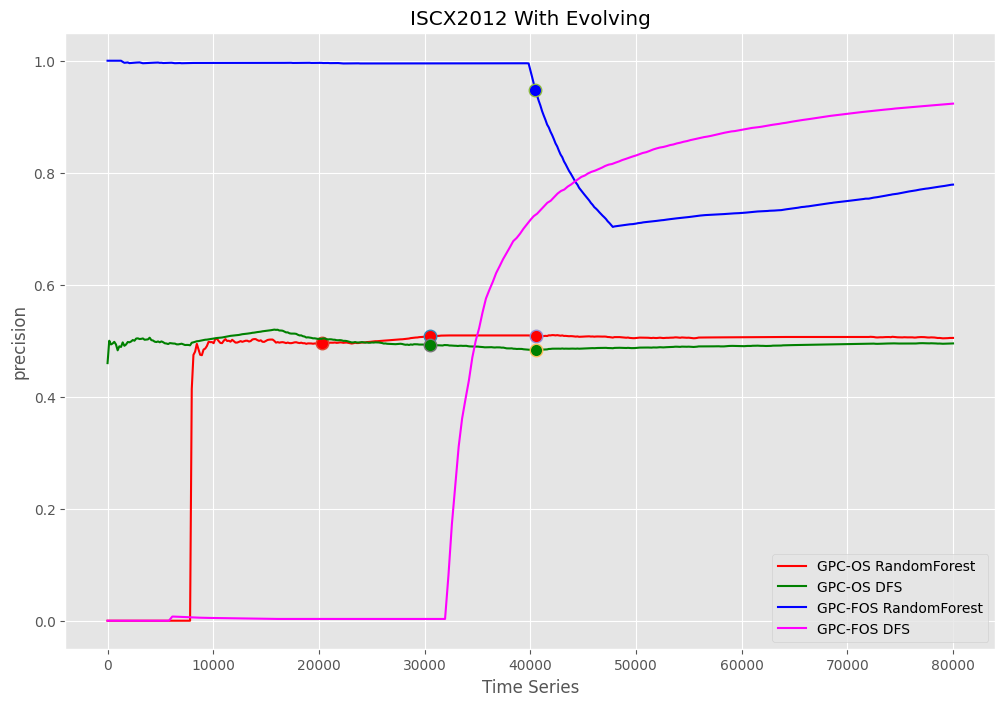

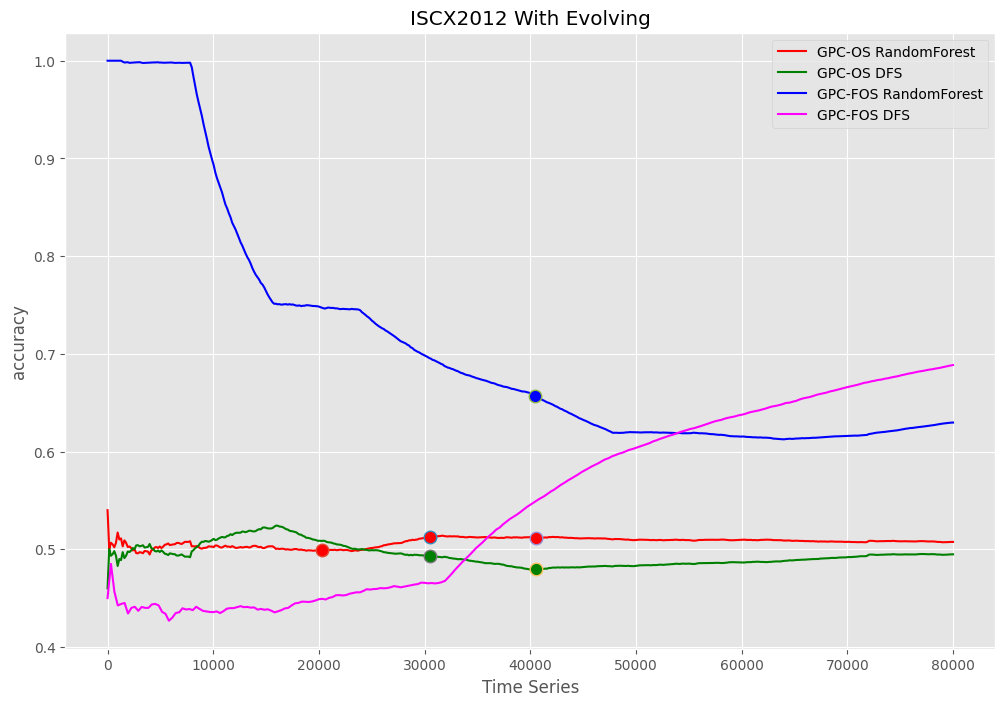

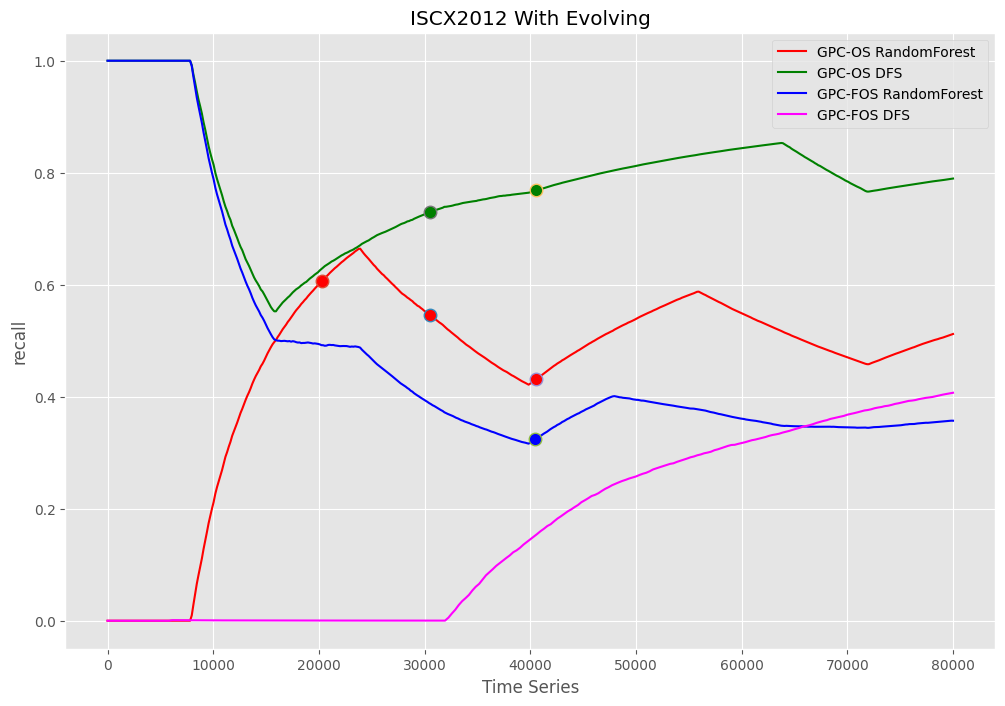

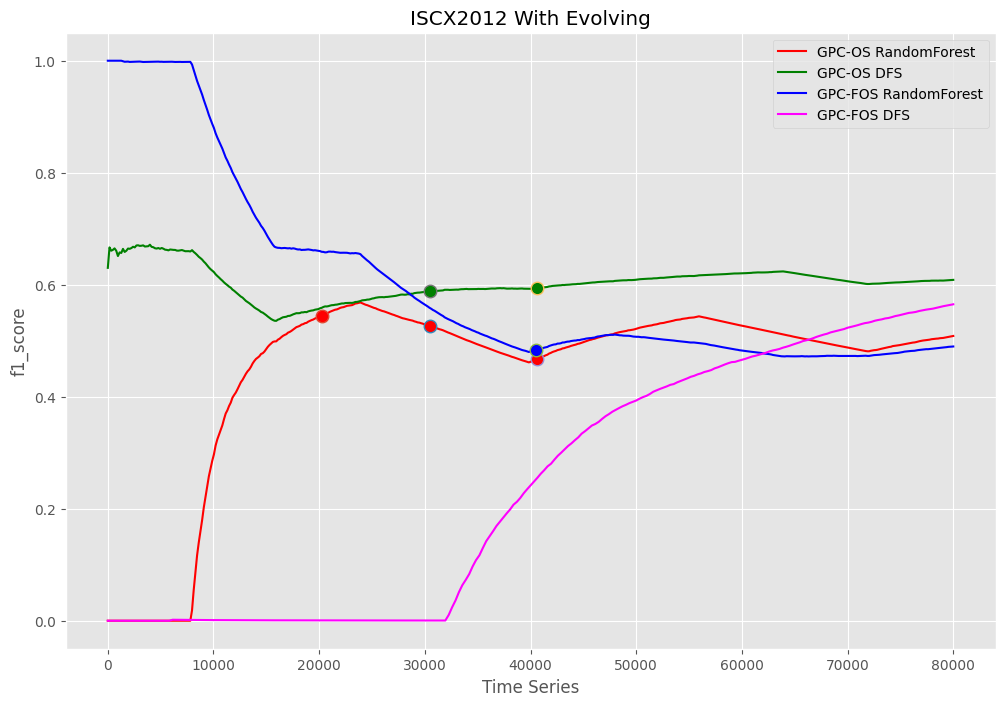

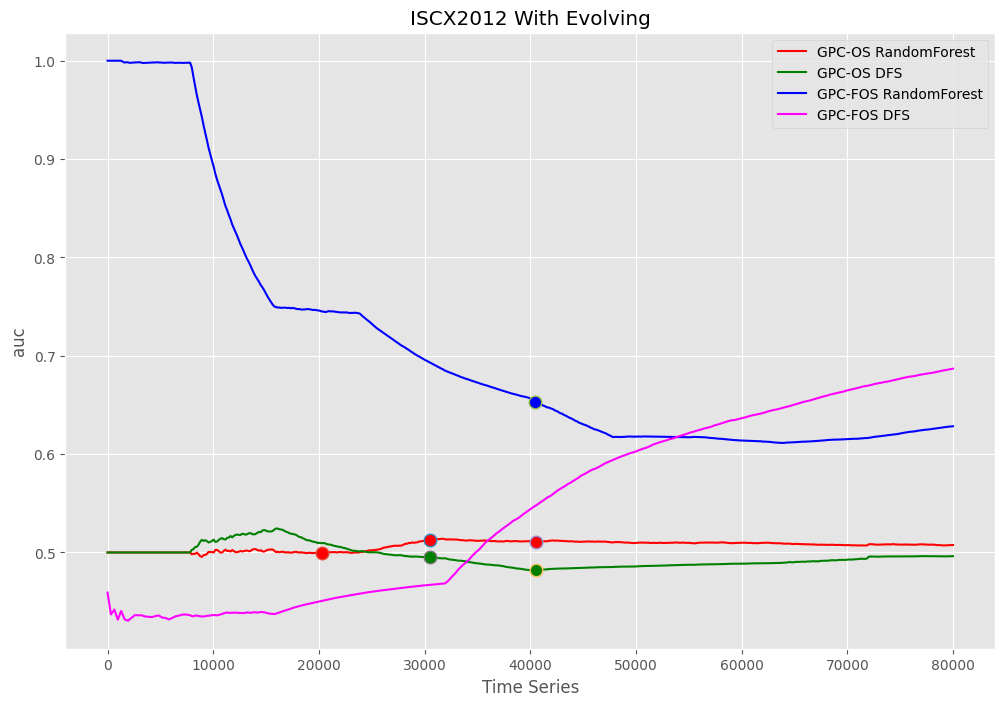

In [ ]:
ISCX2012_results_1 = [
                      "/content/drive/My Drive/Colab Notebooks/Muawiya/Genetic Programming Combiner with DFS/results/gp_combiner_with_model_replacement_evolving_random_forest/ISCX2012.csv/ISCX2012.csv_results.pkl",
                      "/content/drive/My Drive/Colab Notebooks/Muawiya/Genetic Programming Combiner with DFS/results/gp_combiner_with_model_replacement_evolving_DFS/ISCX2012.csv/ISCX2012.csv_results.pkl",
                      "/content/drive/My Drive/Colab Notebooks/Muawiya/Genetic Programming Combiner with DFS/results/faoselm_gp_combiner_with_model_replacement_evolving_random_forest/ISCX2012.csv/ISCX2012.csv_results.pkl",
                      "/content/drive/My Drive/Colab Notebooks/Muawiya/Genetic Programming Combiner with DFS/results/faoselm_gp_combiner_with_model_replacement_evolving_DFS/ISCX2012.csv/ISCX2012.csv_results.pkl",
                      # "/content/drive/My Drive/Colab Notebooks/Muawiya/Genetic Programming Combiner with DFS/results/kpfaoselm_gp_combiner_with_model_replacement_evolving_random_forest/ISCX2012.csv/ISCX2012.csv_results.pkl",
                      # "/content/drive/My Drive/Colab Notebooks/Muawiya/Genetic Programming Combiner with DFS/results/kpfaoselm_gp_combiner_with_model_replacement_evolving_DFS/ISCX2012.csv/ISCX2012.csv_results.pkl",
                      # "/content/drive/My Drive/Colab Notebooks/Muawiya/Genetic Programming Combiner with DFS/results/ml_gp_combiner_with_model_replacement_evolving_random_forest/ISCX2012.csv/ISCX2012.csv_results.pkl",
                      # "/content/drive/My Drive/Colab Notebooks/Muawiya/Genetic Programming Combiner with DFS/results/ml_gp_combiner_with_model_replacement_evolving_DFS/ISCX2012.csv/ISCX2012.csv_results.pkl",
                    ]
drift_location_path = [
                      "/content/drive/My Drive/Colab Notebooks/Muawiya/Genetic Programming Combiner with DFS/results/gp_combiner_with_model_replacement_evolving_random_forest/ISCX2012.csv/ISCX2012.csv_drift_locations_in_all_dataset.pkl",
                      "/content/drive/My Drive/Colab Notebooks/Muawiya/Genetic Programming Combiner with DFS/results/gp_combiner_with_model_replacement_evolving_DFS/ISCX2012.csv/ISCX2012.csv_drift_locations_in_all_dataset.pkl",
                      "/content/drive/My Drive/Colab Notebooks/Muawiya/Genetic Programming Combiner with DFS/results/faoselm_gp_combiner_with_model_replacement_evolving_random_forest/ISCX2012.csv/ISCX2012.csv_drift_locations_in_all_dataset.pkl",
                      "/content/drive/My Drive/Colab Notebooks/Muawiya/Genetic Programming Combiner with DFS/results/faoselm_gp_combiner_with_model_replacement_evolving_DFS/ISCX2012.csv/ISCX2012.csv_drift_locations_in_all_dataset.pkl",
                      # "/content/drive/My Drive/Colab Notebooks/Muawiya/Genetic Programming Combiner with DFS/results/kpfaoselm_gp_combiner_with_model_replacement_evolving_random_forest/ISCX2012.csv/ISCX2012.csv_drift_locations_in_all_dataset.pkl",
                      # "/content/drive/My Drive/Colab Notebooks/Muawiya/Genetic Programming Combiner with DFS/results/kpfaoselm_gp_combiner_with_model_replacement_evolving_DFS/ISCX2012.csv/ISCX2012.csv_drift_locations_in_all_dataset.pkl",
                      # "/content/drive/My Drive/Colab Notebooks/Muawiya/Genetic Programming Combiner with DFS/results/ml_gp_combiner_with_model_replacement_evolving_random_forest/ISCX2012.csv/ISCX2012.csv_drift_locations_in_all_dataset.pkl",
                      # "/content/drive/My Drive/Colab Notebooks/Muawiya/Genetic Programming Combiner with DFS/results/ml_gp_combiner_with_model_replacement_evolving_DFS/ISCX2012.csv/ISCX2012.csv_drift_locations_in_all_dataset.pkl",
                       ]
# try:
time_series_plot(data_path=ISCX2012_results_1, drift_data_path=drift_location_path, step_size=100,
                title=["ISCX2012 With Evolving","ISCX2012"], metric="precision", method_names=method_names)
time_series_plot(data_path=ISCX2012_results_1, drift_data_path=drift_location_path, step_size=100,
                title=["ISCX2012 With Evolving","ISCX2012"], metric="accuracy", method_names=method_names)
time_series_plot(data_path=ISCX2012_results_1, drift_data_path=drift_location_path, step_size=100,
                title=["ISCX2012 With Evolving","ISCX2012"], metric="recall", method_names=method_names)
time_series_plot(data_path=ISCX2012_results_1, drift_data_path=drift_location_path, step_size=100,
                title=["ISCX2012 With Evolving","ISCX2012"], metric="f1_score", method_names=method_names)
time_series_plot(data_path=ISCX2012_results_1, drift_data_path=drift_location_path, step_size=100,
                title=["ISCX2012 With Evolving","ISCX2012"], metric="auc", method_names=method_names)
#   result_as_df(ISCX2012_results_1, metrices, method_names,title="ISCX2012 With Evolving")
# except:
#   print("error in path")

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


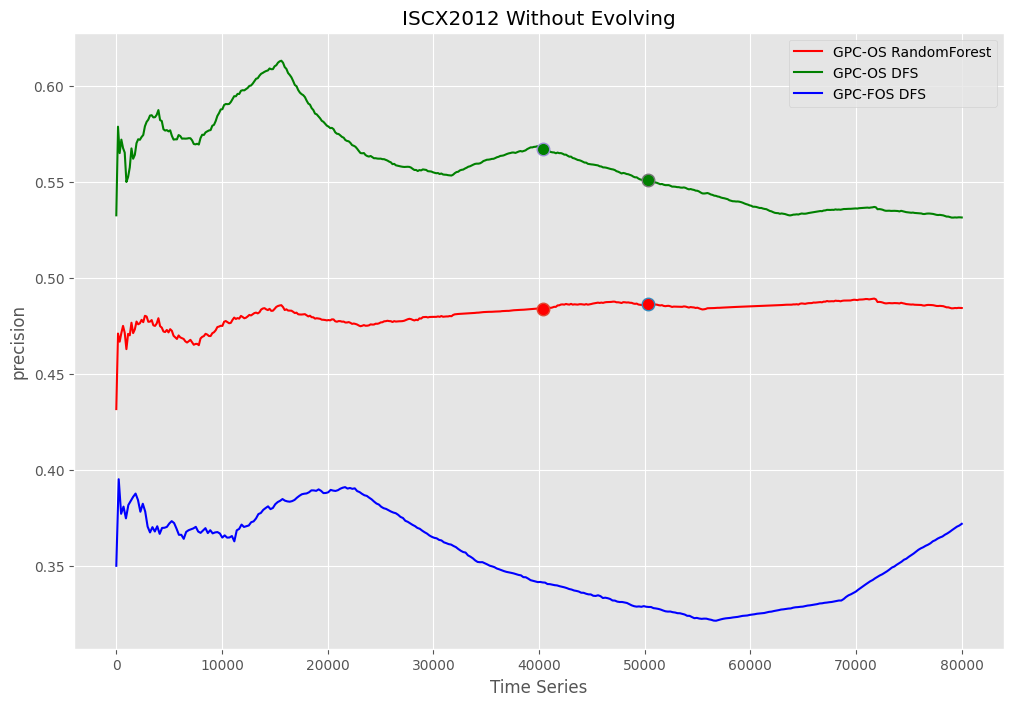

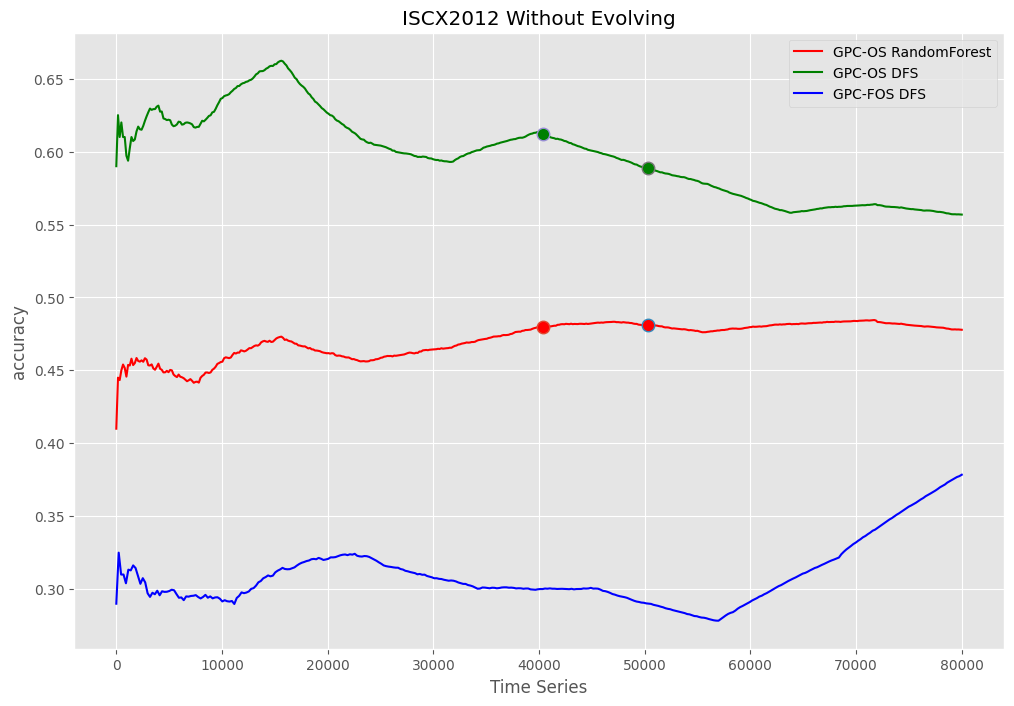

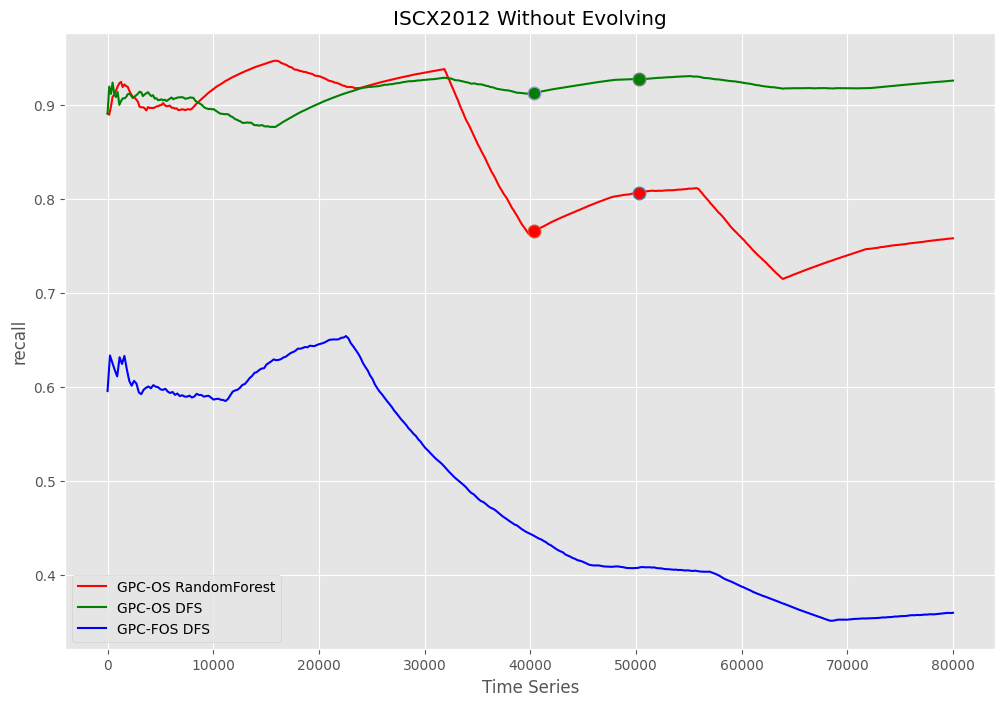

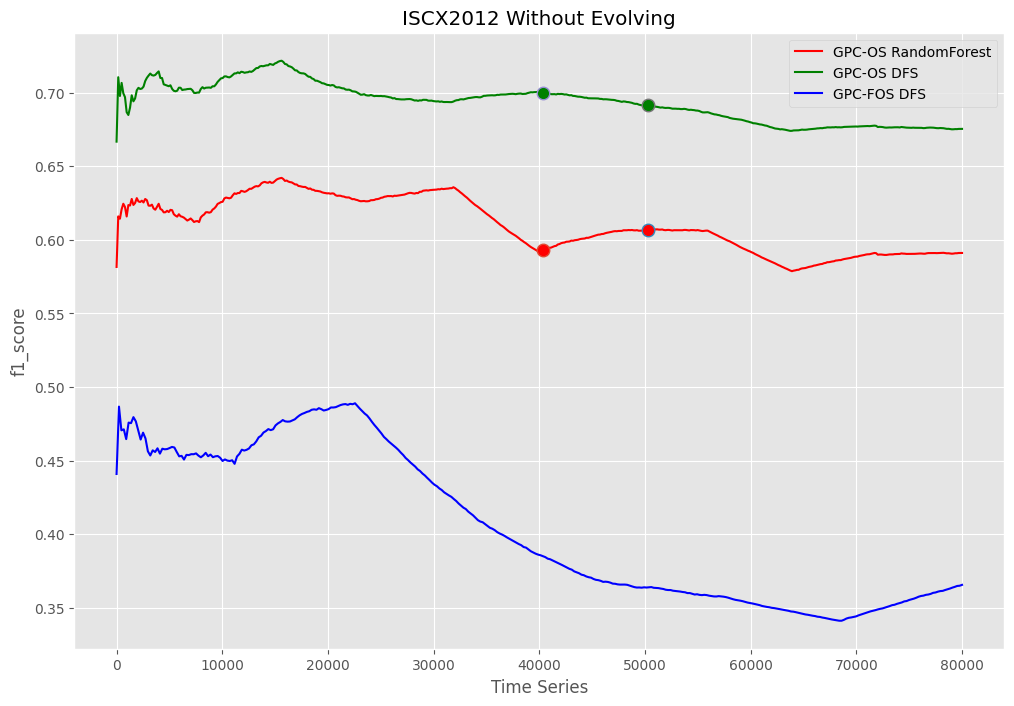

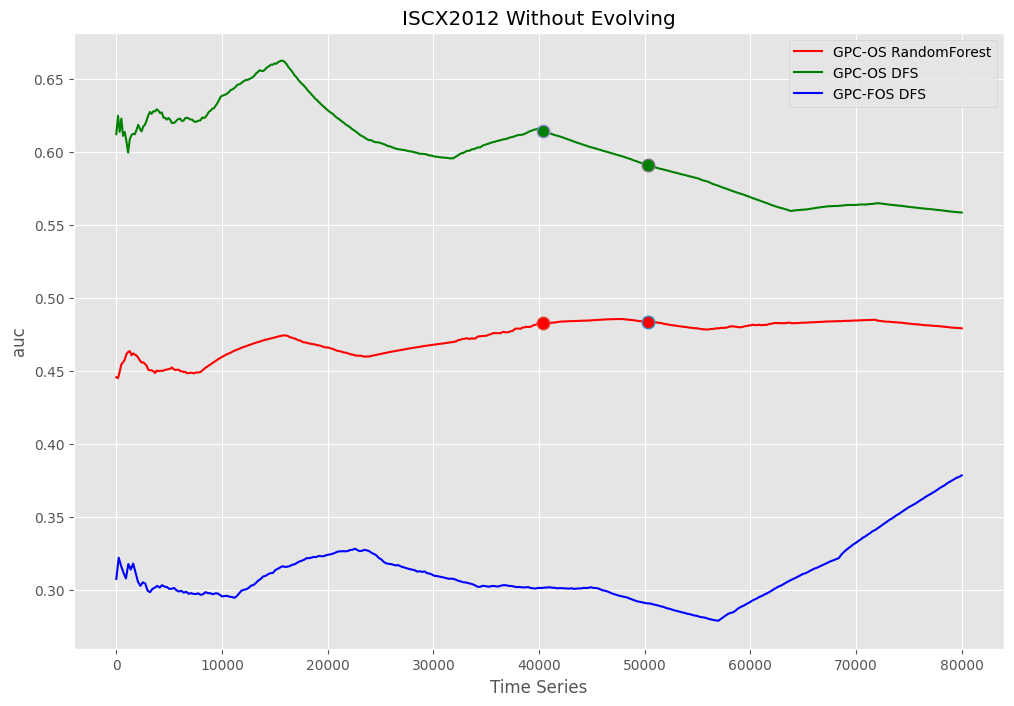

In [ ]:
method_names = ["GPC-OS RandomForest","GPC-OS DFS",
                # "GPC-FOS RandomForest",
                "GPC-FOS DFS ",  "GPC-KOS RandomForest","GPC-KOS DFS","GPC RandomForest", "GPC DFS"]
ISCX2012_results_2 = [
                      "/content/drive/My Drive/Colab Notebooks/Muawiya/Genetic Programming Combiner with DFS/results/gp_combiner_with_model_replacement_random_forest/ISCX2012.csv/ISCX2012.csv_results.pkl",
                      "/content/drive/My Drive/Colab Notebooks/Muawiya/Genetic Programming Combiner with DFS/results/gp_combiner_with_model_replacement_dynamic_feature_selection/ISCX2012.csv/ISCX2012.csv_results.pkl",
                      # "/content/drive/My Drive/Colab Notebooks/Muawiya/Genetic Programming Combiner with DFS/results/faoselm_gp_combiner_with_model_replacement_random_forest/ISCX2012.csv/ISCX2012.csv_results.pkl",
                      "/content/drive/My Drive/Colab Notebooks/Muawiya/Genetic Programming Combiner with DFS/results/faoselm_gp_combiner_with_model_replacement_dynamic_feature_selection/ISCX2012.csv/ISCX2012.csv_results.pkl",
                      # "/content/drive/My Drive/Colab Notebooks/Muawiya/Genetic Programming Combiner with DFS/results/kpfaoselm_gp_combiner_with_model_replacement_random_forest/ISCX2012.csv/ISCX2012.csv_results.pkl",
                      # "/content/drive/My Drive/Colab Notebooks/Muawiya/Genetic Programming Combiner with DFS/results/kpfaoselm_gp_combiner_with_model_replacement_dynamic_feature_selection/ISCX2012.csv/ISCX2012.csv_results.pkl",
                      # "/content/drive/My Drive/Colab Notebooks/Muawiya/Genetic Programming Combiner with DFS/results/ml_gp_combiner_with_model_replacement_random_forest/ISCX2012.csv/ISCX2012.csv_results.pkl",
                      # "/content/drive/My Drive/Colab Notebooks/Muawiya/Genetic Programming Combiner with DFS/results/ml_gp_combiner_with_model_replacement_dynamic_feature_selection/ISCX2012.csv/ISCX2012.csv_results.pkl",
                   ]
drift_location_path = [
                       "/content/drive/My Drive/Colab Notebooks/Muawiya/Genetic Programming Combiner with DFS/results/gp_combiner_with_model_replacement_random_forest/ISCX2012.csv/ISCX2012.csv_drift_locations_in_all_dataset.pkl",
                       "/content/drive/My Drive/Colab Notebooks/Muawiya/Genetic Programming Combiner with DFS/results/gp_combiner_with_model_replacement_dynamic_feature_selection/ISCX2012.csv/ISCX2012.csv_drift_locations_in_all_dataset.pkl",
                      #  "/content/drive/My Drive/Colab Notebooks/Muawiya/Genetic Programming Combiner with DFS/results/faoselm_gp_combiner_with_model_replacement_random_forest/ISCX2012.csv/ISCX2012.csv_drift_locations_in_all_dataset.pkl",
                       "/content/drive/My Drive/Colab Notebooks/Muawiya/Genetic Programming Combiner with DFS/results/faoselm_gp_combiner_with_model_replacement_dynamic_feature_selection/ISCX2012.csv/ISCX2012.csv_drift_locations_in_all_dataset.pkl",
                      #  "/content/drive/My Drive/Colab Notebooks/Muawiya/Genetic Programming Combiner with DFS/results/kpfaoselm_gp_combiner_with_model_replacement_random_forest/ISCX2012.csv/ISCX2012.csv_drift_locations_in_all_dataset.pkl",
                      #  "/content/drive/My Drive/Colab Notebooks/Muawiya/Genetic Programming Combiner with DFS/results/kpfaoselm_gp_combiner_with_model_replacement_dynamic_feature_selection/ISCX2012.csv/ISCX2012.csv_drift_locations_in_all_dataset.pkl",
                      #  "/content/drive/My Drive/Colab Notebooks/Muawiya/Genetic Programming Combiner with DFS/results/ml_gp_combiner_with_model_replacement_random_forest/ISCX2012.csv/ISCX2012.csv_drift_locations_in_all_dataset.pkl",
                      #  "/content/drive/My Drive/Colab Notebooks/Muawiya/Genetic Programming Combiner with DFS/results/ml_gp_combiner_with_model_replacement_dynamic_feature_selection/ISCX2012.csv/ISCX2012.csv_drift_locations_in_all_dataset.pkl",
                       ]
# try:
time_series_plot(data_path=ISCX2012_results_2, drift_data_path=drift_location_path, step_size=100,
                title=["ISCX2012 Without Evolving","ISCX2012"], metric="precision", method_names=method_names)
time_series_plot(data_path=ISCX2012_results_2, drift_data_path=drift_location_path, step_size=100,
                title=["ISCX2012 Without Evolving","ISCX2012"], metric="accuracy", method_names=method_names)
time_series_plot(data_path=ISCX2012_results_2, drift_data_path=drift_location_path, step_size=100,
                title=["ISCX2012 Without Evolving","ISCX2012"], metric="recall", method_names=method_names)
time_series_plot(data_path=ISCX2012_results_2, drift_data_path=drift_location_path, step_size=100,
                title=["ISCX2012 Without Evolving","ISCX2012"], metric="f1_score", method_names=method_names)
time_series_plot(data_path=ISCX2012_results_2, drift_data_path=drift_location_path, step_size=100,
                title=["ISCX2012 Without Evolving","ISCX2012"], metric="auc", method_names=method_names)
#   result_as_df(ISCX2012_results_2, metrices, method_names,title="ISCX2012 Without Evolving")
# except:
#   print("error in path")

In [ ]:
method_names = ["GPC-OS RandomForest","GPC-OS DFS", "GPC-FOS RandomForest","GPC-FOS DFS ",  "GPC-KOS RandomForest","GPC-KOS DFS","GPC RandomForest", "GPC DFS"]

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


# CSE-CIC2018 Result Visualization

In [ ]:
CSE_CIC2018_results_1 = [
                      "/content/drive/My Drive/Colab Notebooks/Muawiya/Genetic Programming Combiner with DFS/results/gp_combiner_with_model_replacement_evolving_random_forest/CSE-CIC2018.csv/CSE-CIC2018.csv_results.pkl",
                      "/content/drive/My Drive/Colab Notebooks/Muawiya/Genetic Programming Combiner with DFS/results/gp_combiner_with_model_replacement_evolving_DFS/CSE-CIC2018.csv/CSE-CIC2018.csv_results.pkl",
                      "/content/drive/My Drive/Colab Notebooks/Muawiya/Genetic Programming Combiner with DFS/results/faoselm_gp_combiner_with_model_replacement_evolving_random_forest/CSE-CIC2018.csv/CSE-CIC2018.csv_results.pkl",
                      "/content/drive/My Drive/Colab Notebooks/Muawiya/Genetic Programming Combiner with DFS/results/faoselm_gp_combiner_with_model_replacement_evolving_DFS/CSE-CIC2018.csv/CSE-CIC2018.csv_results.pkl",
                      # "/content/drive/My Drive/Colab Notebooks/Muawiya/Genetic Programming Combiner with DFS/results/kpfaoselm_gp_combiner_with_model_replacement_evolving_random_forest/CSE-CIC2018.csv/CSE-CIC2018.csv_results.pkl",
                      # "/content/drive/My Drive/Colab Notebooks/Muawiya/Genetic Programming Combiner with DFS/results/kpfaoselm_gp_combiner_with_model_replacement_evolving_DFS/CSE-CIC2018.csv/CSE-CIC2018.csv_results.pkl",
                      # "/content/drive/My Drive/Colab Notebooks/Muawiya/Genetic Programming Combiner with DFS/results/ml_gp_combiner_with_model_replacement_evolving_random_forest/CSE-CIC2018.csv/CSE-CIC2018.csv_results.pkl",
                      # "/content/drive/My Drive/Colab Notebooks/Muawiya/Genetic Programming Combiner with DFS/results/ml_gp_combiner_with_model_replacement_evolving_DFS/CSE-CIC2018.csv/CSE-CIC2018.csv_results.pkl",
                    ]
drift_location_path = [
                      "/content/drive/My Drive/Colab Notebooks/Muawiya/Genetic Programming Combiner with DFS/results/gp_combiner_with_model_replacement_evolving_random_forest/CSE-CIC2018.csv/CSE-CIC2018.csv_drift_locations_in_all_dataset.pkl",
                      "/content/drive/My Drive/Colab Notebooks/Muawiya/Genetic Programming Combiner with DFS/results/gp_combiner_with_model_replacement_evolving_DFS/CSE-CIC2018.csv/CSE-CIC2018.csv_drift_locations_in_all_dataset.pkl",
                      "/content/drive/My Drive/Colab Notebooks/Muawiya/Genetic Programming Combiner with DFS/results/faoselm_gp_combiner_with_model_replacement_evolving_random_forest/CSE-CIC2018.csv/CSE-CIC2018.csv_drift_locations_in_all_dataset.pkl",
                      "/content/drive/My Drive/Colab Notebooks/Muawiya/Genetic Programming Combiner with DFS/results/faoselm_gp_combiner_with_model_replacement_evolving_DFS/CSE-CIC2018.csv/CSE-CIC2018.csv_drift_locations_in_all_dataset.pkl",
                      # "/content/drive/My Drive/Colab Notebooks/Muawiya/Genetic Programming Combiner with DFS/results/kpfaoselm_gp_combiner_with_model_replacement_evolving_random_forest/CSE-CIC2018.csv/CSE-CIC2018.csv_drift_locations_in_all_dataset.pkl",
                      # "/content/drive/My Drive/Colab Notebooks/Muawiya/Genetic Programming Combiner with DFS/results/kpfaoselm_gp_combiner_with_model_replacement_evolving_DFS/CSE-CIC2018.csv/CSE-CIC2018.csv_drift_locations_in_all_dataset.pkl",
                      # "/content/drive/My Drive/Colab Notebooks/Muawiya/Genetic Programming Combiner with DFS/results/ml_gp_combiner_with_model_replacement_evolving_random_forest/CSE-CIC2018.csv/CSE-CIC2018.csv_drift_locations_in_all_dataset.pkl",
                      # "/content/drive/My Drive/Colab Notebooks/Muawiya/Genetic Programming Combiner with DFS/results/ml_gp_combiner_with_model_replacement_evolving_DFS/CSE-CIC2018.csv/CSE-CIC2018.csv_drift_locations_in_all_dataset.pkl",
                       ]
# try:
time_series_plot(data_path=CSE_CIC2018_results_1, drift_data_path=drift_location_path, step_size=100,
                title=["CSE_CIC2018 With Evolving","CSE_CIC2018"], metric="precision", method_names=method_names)
time_series_plot(data_path=CSE_CIC2018_results_1, drift_data_path=drift_location_path, step_size=100,
                title=["CSE_CIC2018 With Evolving","CSE_CIC2018"], metric="accuracy", method_names=method_names)
time_series_plot(data_path=CSE_CIC2018_results_1, drift_data_path=drift_location_path, step_size=100,
                title=["CSE_CIC2018 With Evolving","CSE_CIC2018"], metric="recall", method_names=method_names)
time_series_plot(data_path=CSE_CIC2018_results_1, drift_data_path=drift_location_path, step_size=100,
                title=["CSE_CIC2018 With Evolving","CSE_CIC2018"], metric="f1_score", method_names=method_names)
time_series_plot(data_path=CSE_CIC2018_results_1, drift_data_path=drift_location_path, step_size=100,
                title=["CSE_CIC2018 With Evolving","CSE_CIC2018"], metric="auc", method_names=method_names)
  # result_as_df(CSE_CIC2018_results_1, metrices, method_names,title="CSE_CIC2018 With Evolving")
# except:
#   print("error in path")

In [ ]:
method_names = ["GPC-OS RandomForest","GPC-OS DFS",
                # "GPC-FOS RandomForest",
                "GPC-FOS DFS ",  "GPC-KOS RandomForest","GPC-KOS DFS","GPC RandomForest", "GPC DFS"]
CSE_CIC2018_results_2 = [
                      "/content/drive/My Drive/Colab Notebooks/Muawiya/Genetic Programming Combiner with DFS/results/gp_combiner_with_model_replacement_random_forest/CSE-CIC2018.csv/CSE-CIC2018.csv_results.pkl",
                      "/content/drive/My Drive/Colab Notebooks/Muawiya/Genetic Programming Combiner with DFS/results/gp_combiner_with_model_replacement_dynamic_feature_selection/CSE-CIC2018.csv/CSE-CIC2018.csv_results.pkl",
                      # "/content/drive/My Drive/Colab Notebooks/Muawiya/Genetic Programming Combiner with DFS/results/faoselm_gp_combiner_with_model_replacement_random_forest/CSE-CIC2018.csv/CSE-CIC2018.csv_results.pkl",
                      "/content/drive/My Drive/Colab Notebooks/Muawiya/Genetic Programming Combiner with DFS/results/faoselm_gp_combiner_with_model_replacement_dynamic_feature_selection/CSE-CIC2018.csv/CSE-CIC2018.csv_results.pkl",
                      # "/content/drive/My Drive/Colab Notebooks/Muawiya/Genetic Programming Combiner with DFS/results/kpfaoselm_gp_combiner_with_model_replacement_random_forest/CSE-CIC2018.csv/CSE-CIC2018.csv_results.pkl",
                      # "/content/drive/My Drive/Colab Notebooks/Muawiya/Genetic Programming Combiner with DFS/results/kpfaoselm_gp_combiner_with_model_replacement_dynamic_feature_selection/CSE-CIC2018.csv/CSE-CIC2018.csv_results.pkl",
                      # "/content/drive/My Drive/Colab Notebooks/Muawiya/Genetic Programming Combiner with DFS/results/ml_gp_combiner_with_model_replacement_random_forest/CSE-CIC2018.csv/CSE-CIC2018.csv_results.pkl",
                      # "/content/drive/My Drive/Colab Notebooks/Muawiya/Genetic Programming Combiner with DFS/results/ml_gp_combiner_with_model_replacement_dynamic_feature_selection/CSE-CIC2018.csv/CSE-CIC2018.csv_results.pkl",
                   ]
drift_location_path = [
                       "/content/drive/My Drive/Colab Notebooks/Muawiya/Genetic Programming Combiner with DFS/results/gp_combiner_with_model_replacement_random_forest/CSE-CIC2018.csv/CSE-CIC2018.csv_drift_locations_in_all_dataset.pkl",
                       "/content/drive/My Drive/Colab Notebooks/Muawiya/Genetic Programming Combiner with DFS/results/gp_combiner_with_model_replacement_dynamic_feature_selection/CSE-CIC2018.csv/CSE-CIC2018.csv_drift_locations_in_all_dataset.pkl",
                      #  "/content/drive/My Drive/Colab Notebooks/Muawiya/Genetic Programming Combiner with DFS/results/faoselm_gp_combiner_with_model_replacement_random_forest/CSE-CIC2018.csv/CSE-CIC2018.csv_drift_locations_in_all_dataset.pkl",
                       "/content/drive/My Drive/Colab Notebooks/Muawiya/Genetic Programming Combiner with DFS/results/faoselm_gp_combiner_with_model_replacement_dynamic_feature_selection/CSE-CIC2018.csv/CSE-CIC2018.csv_drift_locations_in_all_dataset.pkl",
                      #  "/content/drive/My Drive/Colab Notebooks/Muawiya/Genetic Programming Combiner with DFS/results/kpfaoselm_gp_combiner_with_model_replacement_random_forest/CSE-CIC2018.csv/CSE-CIC2018.csv_drift_locations_in_all_dataset.pkl",
                      #  "/content/drive/My Drive/Colab Notebooks/Muawiya/Genetic Programming Combiner with DFS/results/kpfaoselm_gp_combiner_with_model_replacement_dynamic_feature_selection/CSE-CIC2018.csv/CSE-CIC2018.csv_drift_locations_in_all_dataset.pkl",
                      #  "/content/drive/My Drive/Colab Notebooks/Muawiya/Genetic Programming Combiner with DFS/results/ml_gp_combiner_with_model_replacement_random_forest/CSE-CIC2018.csv/CSE-CIC2018.csv_drift_locations_in_all_dataset.pkl",
                      #  "/content/drive/My Drive/Colab Notebooks/Muawiya/Genetic Programming Combiner with DFS/results/ml_gp_combiner_with_model_replacement_dynamic_feature_selection/CSE-CIC2018.csv/CSE-CIC2018.csv_drift_locations_in_all_dataset.pkl",
                       ]
# try:
time_series_plot(data_path=CSE_CIC2018_results_2, drift_data_path=drift_location_path, step_size=100,
                title=["CSE_CIC2018 Without Evolving","CSE_CIC2018"], metric="precision", method_names=method_names)
time_series_plot(data_path=CSE_CIC2018_results_2, drift_data_path=drift_location_path, step_size=100,
                title=["CSE_CIC2018 Without Evolving","CSE_CIC2018"], metric="accuracy", method_names=method_names)
time_series_plot(data_path=CSE_CIC2018_results_2, drift_data_path=drift_location_path, step_size=100,
                title=["CSE_CIC2018 Without Evolving","CSE_CIC2018"], metric="recall", method_names=method_names)
time_series_plot(data_path=CSE_CIC2018_results_2, drift_data_path=drift_location_path, step_size=100,
                title=["CSE_CIC2018 Without Evolving","CSE_CIC2018"], metric="f1_score", method_names=method_names)
time_series_plot(data_path=CSE_CIC2018_results_2, drift_data_path=drift_location_path, step_size=100,
                title=["CSE_CIC2018 Without Evolving","CSE_CIC2018"], metric="auc", method_names=method_names)
#   result_as_df(CSE_CIC2018_results_2, metrices, method_names,title="CSE_CIC2018 Without Evolving")
# except:
#   print("error in path")

In [ ]:
method_names = ["GPC-OS RandomForest","GPC-OS DFS", "GPC-FOS RandomForest","GPC-FOS DFS ",  "GPC-KOS RandomForest","GPC-KOS DFS","GPC RandomForest", "GPC DFS"]

# CICIDS2017 Result Visualization

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defin

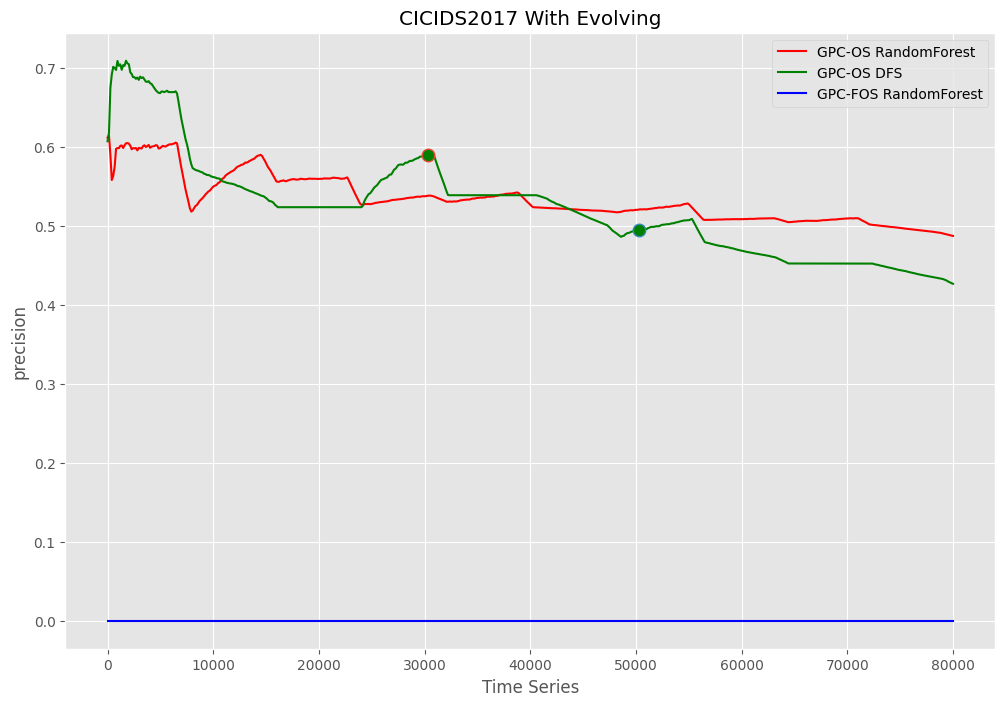

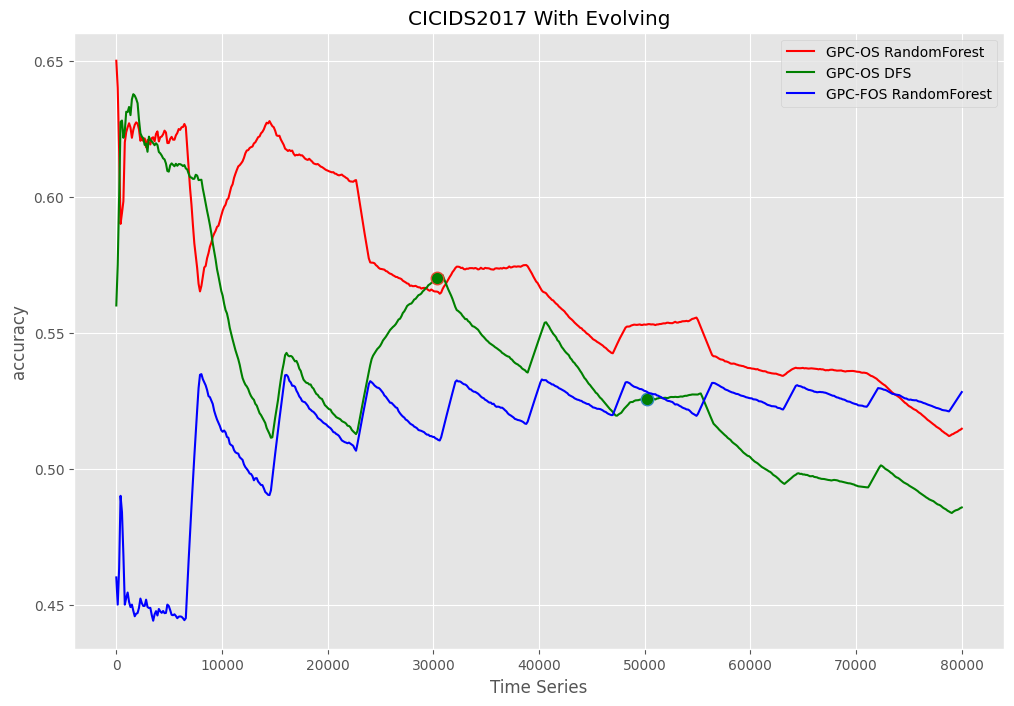

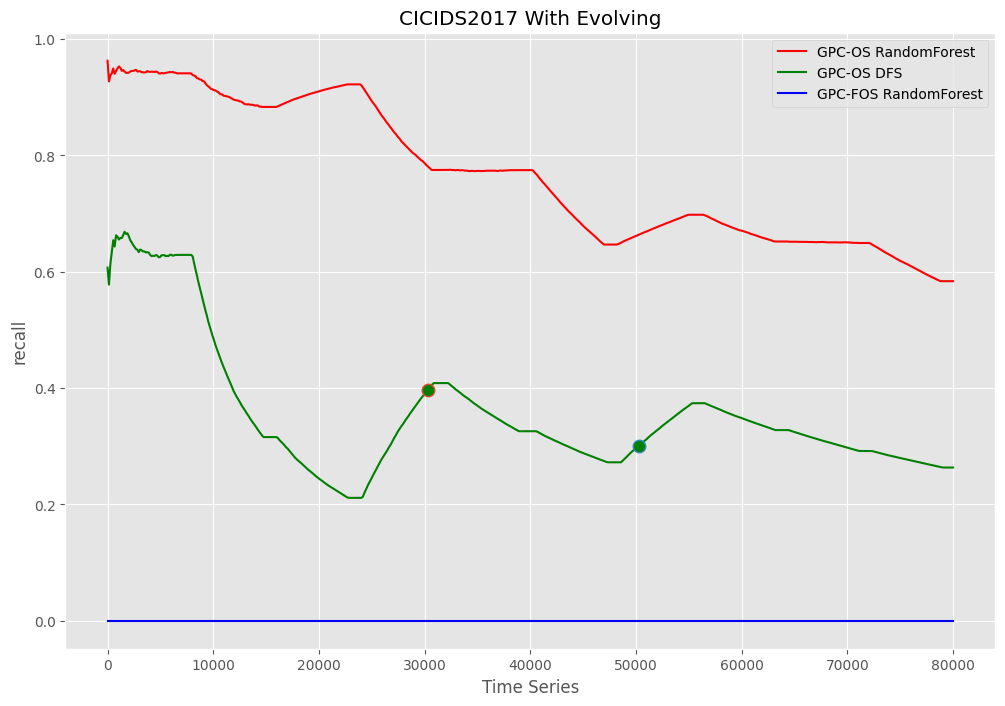

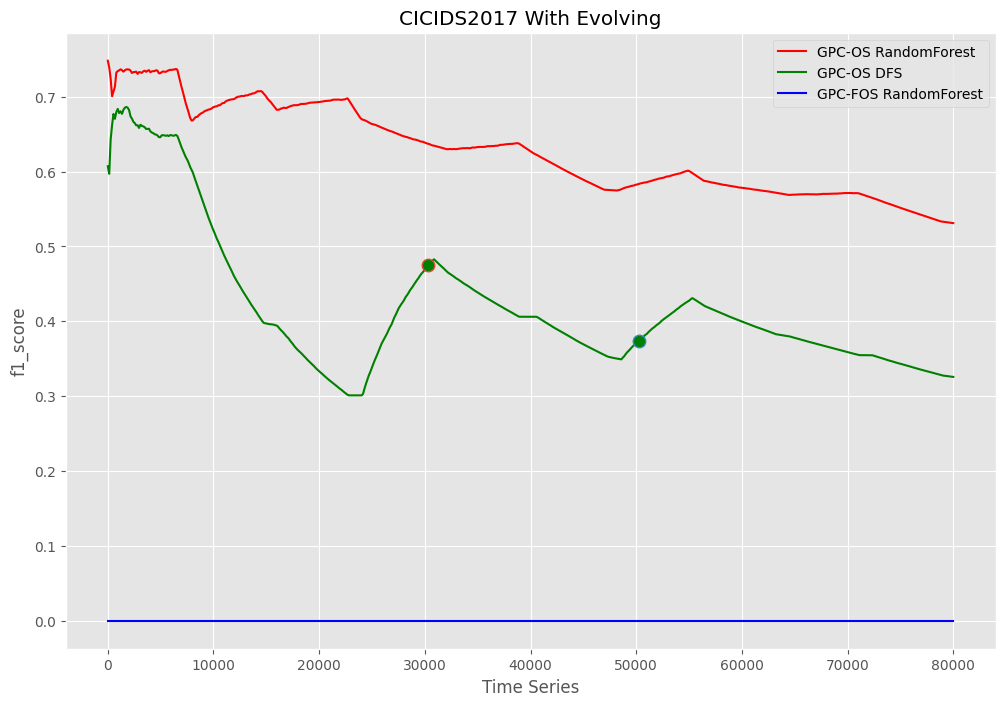

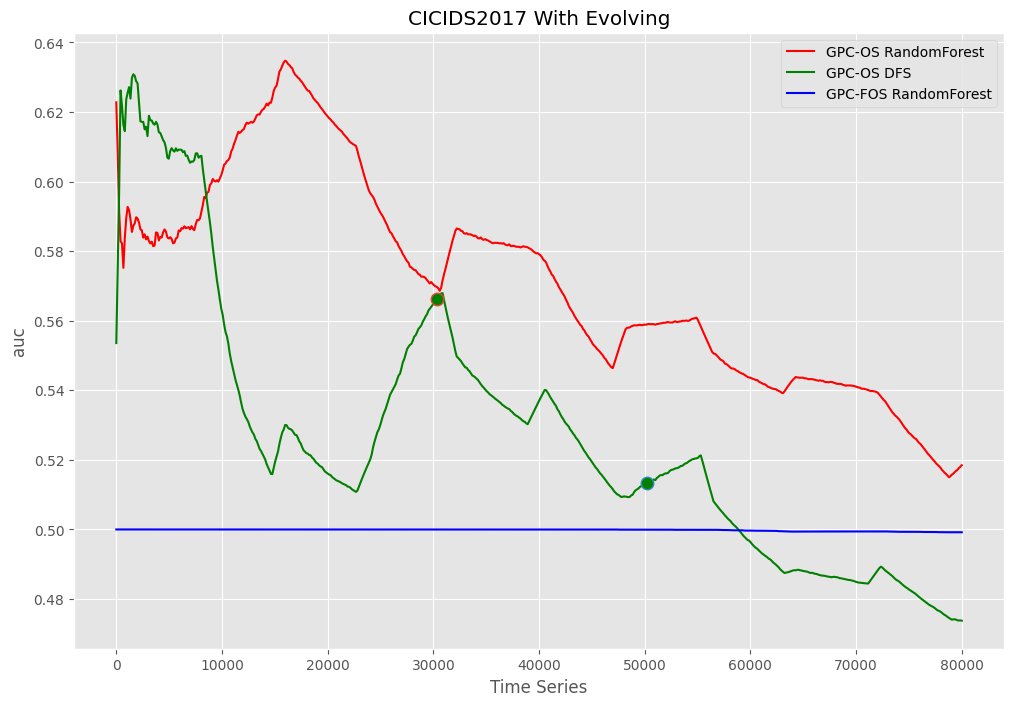

In [ ]:
CICIDS2017_results_1 = [
                      "/content/drive/My Drive/Colab Notebooks/Muawiya/Genetic Programming Combiner with DFS/results/gp_combiner_with_model_replacement_evolving_random_forest/CICIDS2017.csv/CICIDS2017.csv_results.pkl",
                      "/content/drive/My Drive/Colab Notebooks/Muawiya/Genetic Programming Combiner with DFS/results/gp_combiner_with_model_replacement_evolving_DFS/CICIDS2017.csv/CICIDS2017.csv_results.pkl",
                      "/content/drive/My Drive/Colab Notebooks/Muawiya/Genetic Programming Combiner with DFS/results/faoselm_gp_combiner_with_model_replacement_evolving_random_forest/CICIDS2017.csv/CICIDS2017.csv_results.pkl",
                      # "/content/drive/My Drive/Colab Notebooks/Muawiya/Genetic Programming Combiner with DFS/results/faoselm_gp_combiner_with_model_replacement_evolving_DFS/CICIDS2017.csv/CICIDS2017.csv_results.pkl",
                      # "/content/drive/My Drive/Colab Notebooks/Muawiya/Genetic Programming Combiner with DFS/results/kpfaoselm_gp_combiner_with_model_replacement_evolving_random_forest/CICIDS2017.csv/CICIDS2017.csv_results.pkl",
                      # "/content/drive/My Drive/Colab Notebooks/Muawiya/Genetic Programming Combiner with DFS/results/kpfaoselm_gp_combiner_with_model_replacement_evolving_DFS/CICIDS2017.csv/CICIDS2017.csv_results.pkl",
                      # "/content/drive/My Drive/Colab Notebooks/Muawiya/Genetic Programming Combiner with DFS/results/ml_gp_combiner_with_model_replacement_evolving_random_forest/CICIDS2017.csv/CICIDS2017.csv_results.pkl",
                      # "/content/drive/My Drive/Colab Notebooks/Muawiya/Genetic Programming Combiner with DFS/results/ml_gp_combiner_with_model_replacement_evolving_DFS/CICIDS2017.csv/CICIDS2017.csv_results.pkl",
                    ]
drift_location_path = [
                      "/content/drive/My Drive/Colab Notebooks/Muawiya/Genetic Programming Combiner with DFS/results/gp_combiner_with_model_replacement_evolving_random_forest/CICIDS2017.csv/CICIDS2017.csv_drift_locations_in_all_dataset.pkl",
                      "/content/drive/My Drive/Colab Notebooks/Muawiya/Genetic Programming Combiner with DFS/results/gp_combiner_with_model_replacement_evolving_DFS/CICIDS2017.csv/CICIDS2017.csv_drift_locations_in_all_dataset.pkl",
                      "/content/drive/My Drive/Colab Notebooks/Muawiya/Genetic Programming Combiner with DFS/results/faoselm_gp_combiner_with_model_replacement_evolving_random_forest/CICIDS2017.csv/CICIDS2017.csv_drift_locations_in_all_dataset.pkl",
                      # "/content/drive/My Drive/Colab Notebooks/Muawiya/Genetic Programming Combiner with DFS/results/faoselm_gp_combiner_with_model_replacement_evolving_DFS/CICIDS2017.csv/CICIDS2017.csv_drift_locations_in_all_dataset.pkl",
                      # "/content/drive/My Drive/Colab Notebooks/Muawiya/Genetic Programming Combiner with DFS/results/kpfaoselm_gp_combiner_with_model_replacement_evolving_random_forest/CICIDS2017.csv/CICIDS2017.csv_drift_locations_in_all_dataset.pkl",
                      # "/content/drive/My Drive/Colab Notebooks/Muawiya/Genetic Programming Combiner with DFS/results/kpfaoselm_gp_combiner_with_model_replacement_evolving_DFS/CICIDS2017.csv/CICIDS2017.csv_drift_locations_in_all_dataset.pkl",
                      # "/content/drive/My Drive/Colab Notebooks/Muawiya/Genetic Programming Combiner with DFS/results/ml_gp_combiner_with_model_replacement_evolving_random_forest/CICIDS2017.csv/CICIDS2017.csv_drift_locations_in_all_dataset.pkl",
                      # "/content/drive/My Drive/Colab Notebooks/Muawiya/Genetic Programming Combiner with DFS/results/ml_gp_combiner_with_model_replacement_evolving_DFS/CICIDS2017.csv/CICIDS2017.csv_drift_locations_in_all_dataset.pkl",
                       ]
# try:
time_series_plot(data_path=CICIDS2017_results_1, drift_data_path=drift_location_path, step_size=100,
                title=["CICIDS2017 With Evolving","CICIDS2017"], metric="precision", method_names=method_names)
time_series_plot(data_path=CICIDS2017_results_1, drift_data_path=drift_location_path, step_size=100,
                title=["CICIDS2017 With Evolving","CICIDS2017"], metric="accuracy", method_names=method_names)
time_series_plot(data_path=CICIDS2017_results_1, drift_data_path=drift_location_path, step_size=100,
                title=["CICIDS2017 With Evolving","CICIDS2017"], metric="recall", method_names=method_names)
time_series_plot(data_path=CICIDS2017_results_1, drift_data_path=drift_location_path, step_size=100,
                title=["CICIDS2017 With Evolving","CICIDS2017"], metric="f1_score", method_names=method_names)
time_series_plot(data_path=CICIDS2017_results_1, drift_data_path=drift_location_path, step_size=100,
                title=["CICIDS2017 With Evolving","CICIDS2017"], metric="auc", method_names=method_names)
#   result_as_df(CICIDS2017_results_1, metrices, method_names,title="ISCX2012 With Evolving")
# except:
#   print("error in path")

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


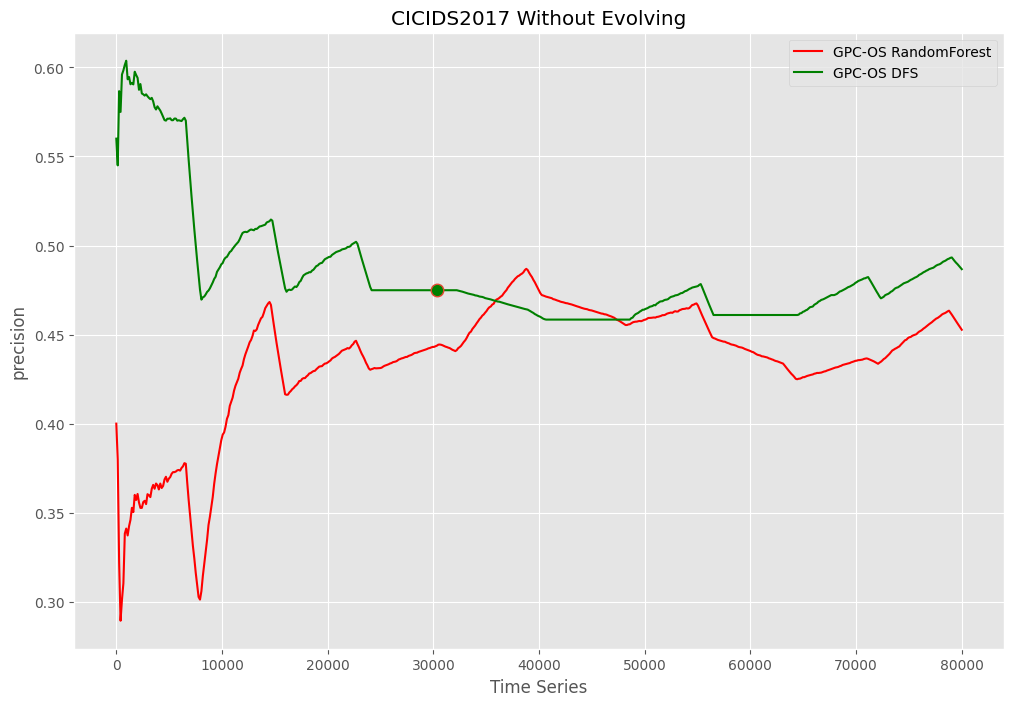

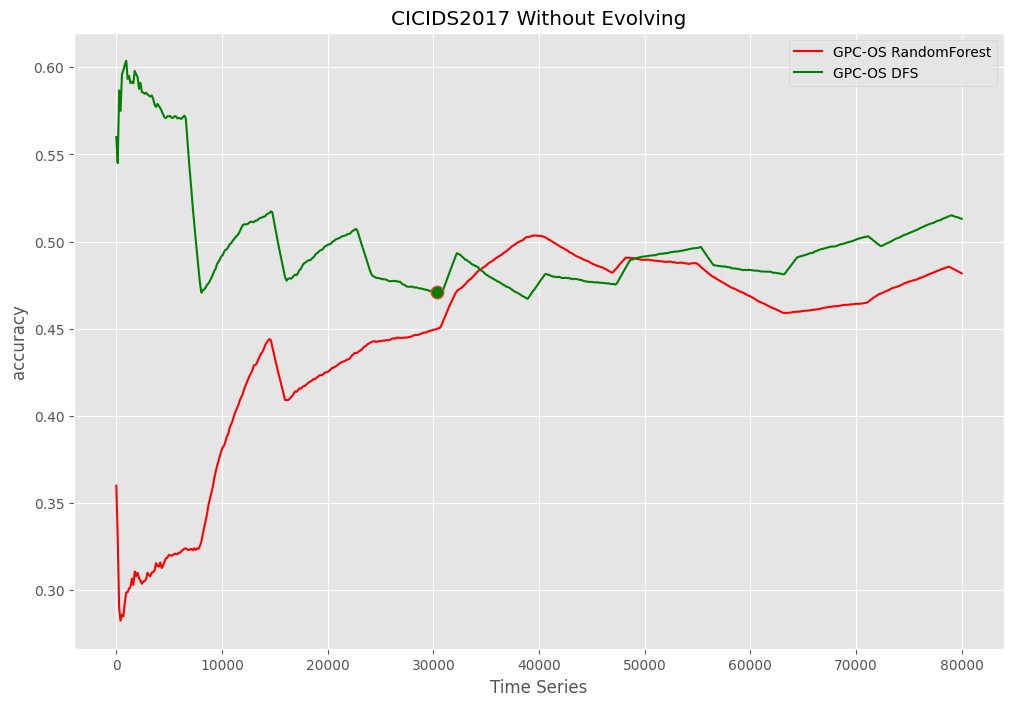

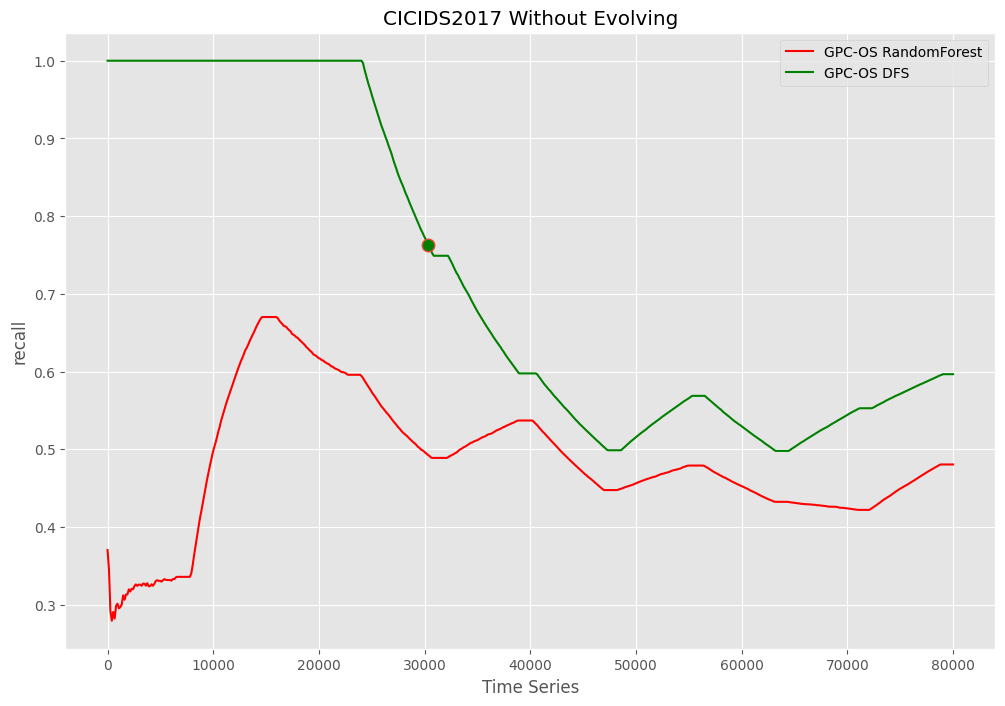

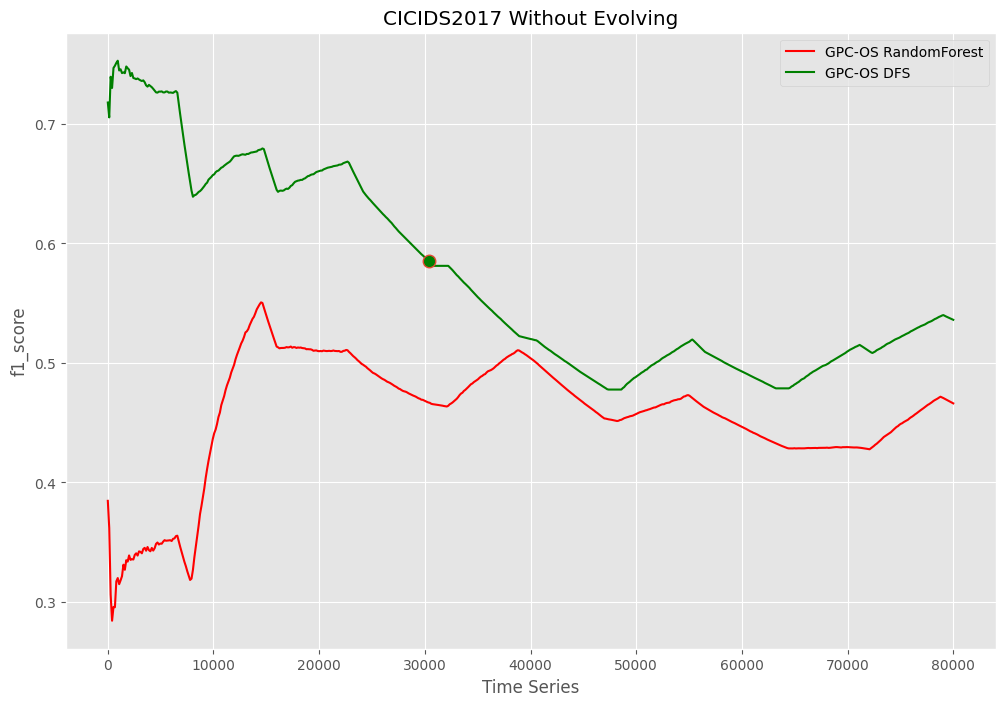

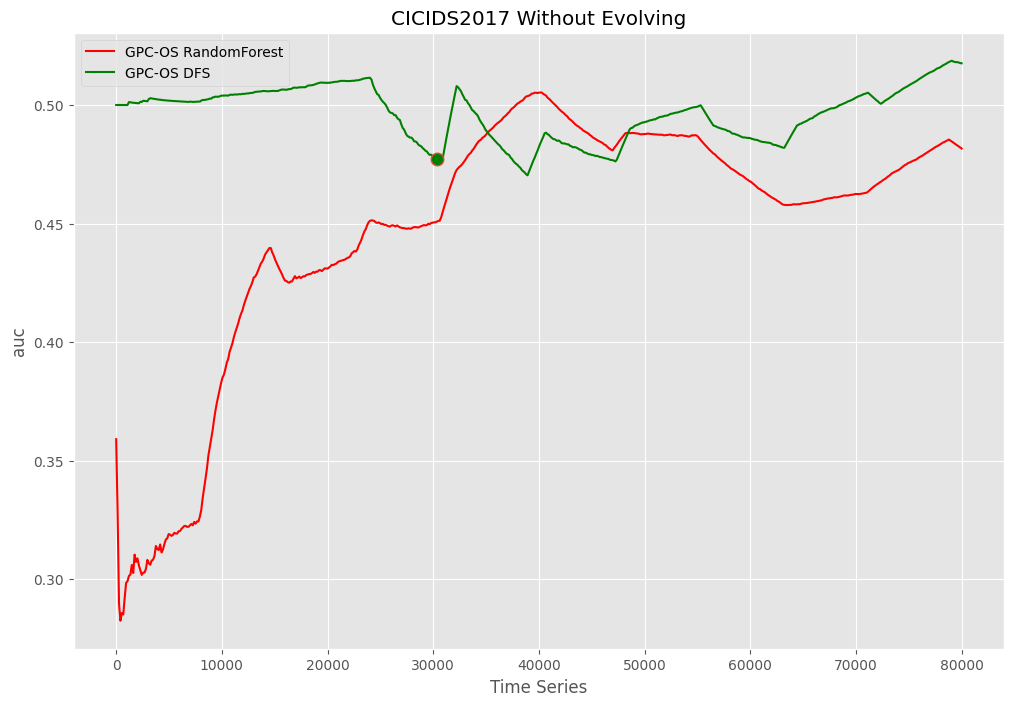

In [ ]:
CICIDS2017_results_2 = [
                      "/content/drive/My Drive/Colab Notebooks/Muawiya/Genetic Programming Combiner with DFS/results/gp_combiner_with_model_replacement_random_forest/CICIDS2017.csv/CICIDS2017.csv_results.pkl",
                      "/content/drive/My Drive/Colab Notebooks/Muawiya/Genetic Programming Combiner with DFS/results/gp_combiner_with_model_replacement_dynamic_feature_selection/CICIDS2017.csv/CICIDS2017.csv_results.pkl",
                      # "/content/drive/My Drive/Colab Notebooks/Muawiya/Genetic Programming Combiner with DFS/results/faoselm_gp_combiner_with_model_replacement_random_forest/CICIDS2017.csv/CICIDS2017.csv_results.pkl",
                      # "/content/drive/My Drive/Colab Notebooks/Muawiya/Genetic Programming Combiner with DFS/results/faoselm_gp_combiner_with_model_replacement_dynamic_feature_selection/CICIDS2017.csv/CICIDS2017.csv_results.pkl",
                      # "/content/drive/My Drive/Colab Notebooks/Muawiya/Genetic Programming Combiner with DFS/results/kpfaoselm_gp_combiner_with_model_replacement_random_forest/CICIDS2017.csv/CICIDS2017.csv_results.pkl",
                      # "/content/drive/My Drive/Colab Notebooks/Muawiya/Genetic Programming Combiner with DFS/results/kpfaoselm_gp_combiner_with_model_replacement_dynamic_feature_selection/CICIDS2017.csv/CICIDS2017.csv_results.pkl",
                      # "/content/drive/My Drive/Colab Notebooks/Muawiya/Genetic Programming Combiner with DFS/results/ml_gp_combiner_with_model_replacement_random_forest/CICIDS2017.csv/CICIDS2017.csv_results.pkl",
                      # "/content/drive/My Drive/Colab Notebooks/Muawiya/Genetic Programming Combiner with DFS/results/ml_gp_combiner_with_model_replacement_dynamic_feature_selection/CICIDS2017.csv/CICIDS2017.csv_results.pkl",
                   ]
drift_location_path = [
                       "/content/drive/My Drive/Colab Notebooks/Muawiya/Genetic Programming Combiner with DFS/results/gp_combiner_with_model_replacement_random_forest/CICIDS2017.csv/CICIDS2017.csv_drift_locations_in_all_dataset.pkl",
                       "/content/drive/My Drive/Colab Notebooks/Muawiya/Genetic Programming Combiner with DFS/results/gp_combiner_with_model_replacement_dynamic_feature_selection/CICIDS2017.csv/CICIDS2017.csv_drift_locations_in_all_dataset.pkl",
                      #  "/content/drive/My Drive/Colab Notebooks/Muawiya/Genetic Programming Combiner with DFS/results/faoselm_gp_combiner_with_model_replacement_random_forest/CICIDS2017.csv/CICIDS2017.csv_drift_locations_in_all_dataset.pkl",
                      #  "/content/drive/My Drive/Colab Notebooks/Muawiya/Genetic Programming Combiner with DFS/results/faoselm_gp_combiner_with_model_replacement_dynamic_feature_selection/CICIDS2017.csv/CICIDS2017.csv_drift_locations_in_all_dataset.pkl",
                      #  "/content/drive/My Drive/Colab Notebooks/Muawiya/Genetic Programming Combiner with DFS/results/kpfaoselm_gp_combiner_with_model_replacement_random_forest/CICIDS2017.csv/CICIDS2017.csv_drift_locations_in_all_dataset.pkl",
                      #  "/content/drive/My Drive/Colab Notebooks/Muawiya/Genetic Programming Combiner with DFS/results/kpfaoselm_gp_combiner_with_model_replacement_dynamic_feature_selection/CICIDS2017.csv/CICIDS2017.csv_drift_locations_in_all_dataset.pkl",
                      #  "/content/drive/My Drive/Colab Notebooks/Muawiya/Genetic Programming Combiner with DFS/results/ml_gp_combiner_with_model_replacement_random_forest/CICIDS2017.csv/CICIDS2017.csv_drift_locations_in_all_dataset.pkl",
                      #  "/content/drive/My Drive/Colab Notebooks/Muawiya/Genetic Programming Combiner with DFS/results/ml_gp_combiner_with_model_replacement_dynamic_feature_selection/CICIDS2017.csv/CICIDS2017.csv_drift_locations_in_all_dataset.pkl",
                       ]
# try:
time_series_plot(data_path=CICIDS2017_results_2, drift_data_path=drift_location_path, step_size=100,
                title=["CICIDS2017 Without Evolving","CICIDS2017"], metric="precision", method_names=method_names)
time_series_plot(data_path=CICIDS2017_results_2, drift_data_path=drift_location_path, step_size=100,
                title=["CICIDS2017 Without Evolving","CICIDS2017"], metric="accuracy", method_names=method_names)
time_series_plot(data_path=CICIDS2017_results_2, drift_data_path=drift_location_path, step_size=100,
                title=["CICIDS2017 Without Evolving","CICIDS2017"], metric="recall", method_names=method_names)
time_series_plot(data_path=CICIDS2017_results_2, drift_data_path=drift_location_path, step_size=100,
                title=["CICIDS2017 Without Evolving","CICIDS2017"], metric="f1_score", method_names=method_names)
time_series_plot(data_path=CICIDS2017_results_2, drift_data_path=drift_location_path, step_size=100,
                title=["CICIDS2017 Without Evolving","CICIDS2017"], metric="auc", method_names=method_names)
#   result_as_df(CICIDS2017_results_2, metrices, method_names,title="CICIDS2017 Without Evolving")
# except:
#   print("error in path")

# Bar chart plot for all datasets

In [ ]:
all_result_path = gradual_results_1 + blip_results_1 + recurrent_results_1 + sudden_results_1 + incremental_results_1 + kddcup99_results_1 + ISCX2012_results_1 + CSE_CIC2018_results_1 + CICIDS2017_results_1
data_set_names = ['Gradual', 'Blip', 'Recurrent', 'Sudden', 'Incremental', 'KDDCUP99', 'ISCX2012', 'CSE-CIC2018', 'CICIDS2017']
all_result_path

In [ ]:
bar_chart_plot(data_path=all_result_path,
               title="Accuracy Comparision", metric="accuracy", method_names=method_names, xticks=data_set_names) # Synthetic

In [ ]:
bar_chart_plot(data_path=all_result_path,
               title="Precision Comparision", metric="precision", method_names=method_names, xticks=data_set_names)

In [ ]:
bar_chart_plot(data_path=all_result_path,
               title="Recall Comparision", metric="recall", method_names=method_names, xticks=data_set_names)

In [ ]:
bar_chart_plot(data_path=all_result_path,
               title="F1_score Comparision", metric="f1_score", method_names=method_names, xticks=data_set_names)

In [ ]:
bar_chart_plot(data_path=all_result_path,
               title="Auc Comparision", metric="auc", method_names=method_names, xticks=data_set_names)

In [ ]:
all_result_path = gradual_results_2 + blip_results_2 + recurrent_results_2 + sudden_results_2 + incremental_results_2 + kddcup99_results_2 + ISCX2012_results_2 + CSE_CIC2018_results_2 + CICIDS2017_results_2
data_set_names = ['Gradual', 'Blip', 'Recurrent', 'Sudden', 'Incremental', 'KDDCUP99', 'ISCX2012', 'CSE-CIC2018', 'CICIDS2017']
all_result_path

In [ ]:
bar_chart_plot(data_path=all_result_path,
               title="Accuracy Comparision", metric="accuracy", method_names=method_names, xticks=data_set_names)

In [ ]:
bar_chart_plot(data_path=all_result_path,
               title="Precision Comparision", metric="precision", method_names=method_names, xticks=data_set_names)

In [ ]:
bar_chart_plot(data_path=all_result_path,
               title="Recall Comparision", metric="recall", method_names=method_names, xticks=data_set_names)

In [ ]:
bar_chart_plot(data_path=all_result_path,
               title="F1_score Comparision", metric="f1_score", method_names=method_names, xticks=data_set_names)

In [ ]:
bar_chart_plot(data_path=all_result_path,
               title="Auc Comparision", metric="auc", method_names=method_names, xticks=data_set_names)